In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from pathlib import Path
import pickle
import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch 

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
parent_dir = Path(home_directory).resolve() #TJ current notebook's parent directory
os.chdir(parent_dir) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Image_vs_spectra import *
from Py_files.Convolution_script import *

#IFU_files = glob.glob('Data_files/IFU_files/*s3d.fits') #TJ this is not correctly sorted, run this and copy into line below
karin_SDuval_IFU_files = ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch4-shortmediumlong_s3d.fits'
            ]

karin_IFU_files = [ 'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch4-shortmediumlong_s3d.fits',
            ]
Thomas_IFU_file = 'Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits'

SDuval_IFU_files = ['Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits',
                  'Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits',
                  'Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits',
                  'Data_files/IFU_files/raw_IFUs/SW_IFU_ch4-shortmediumlong_s3d.fits']

Grant_conv_IFU_files = ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d_conv17p1um.fits']
pivot_files = []
for i in range(1,8):
    pivot_files.append(f'Data_files/IFU_files/convolved_to_2100_part{i}.fits')
jw_files = glob.glob('Data_files/IFU_files/my_convolutions/*/jw*')
sw_files = glob.glob('Data_files/IFU_files/my_convolutions/*/SW*')
my_convolutions = np.concatenate([jw_files, sw_files])
image_files, filter_files = generate_list_of_files()
filter_names = ['F115W', 'F140M', 'F150W', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F300M', 'F335M', 'F360M', 'F405N', 
           'F430M', 'F444W', 'F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W'] 
loc = [202.4340450, 47.1732517]
test_loc = [202.43357, 47.17296]

radius = 0.75*u.arcsec
with open('Data_files/misc_data/flux_v_radius/maximum_radii.dic', 'rb') as f:
    radius_dict = pickle.load(f)

True
/d/ret1/Taylor/stpsf-data/


In [116]:

hdu = fits.open(karin_IFU_files[1])['SCI']
loc_deg = np.array(loc)*u.deg
coord = SkyCoord(ra=loc_deg[0], dec=loc_deg[1], frame='icrs')

# Convert to HMS / DMS
ra_hms = coord.ra.to_string(unit=u.hour, sep=':', precision=2)
dec_dms = coord.dec.to_string(unit=u.degree, sep=':', precision=2, alwayssign=True)
print(ra_hms, dec_dms)



13:29:44.17 +47:10:23.71


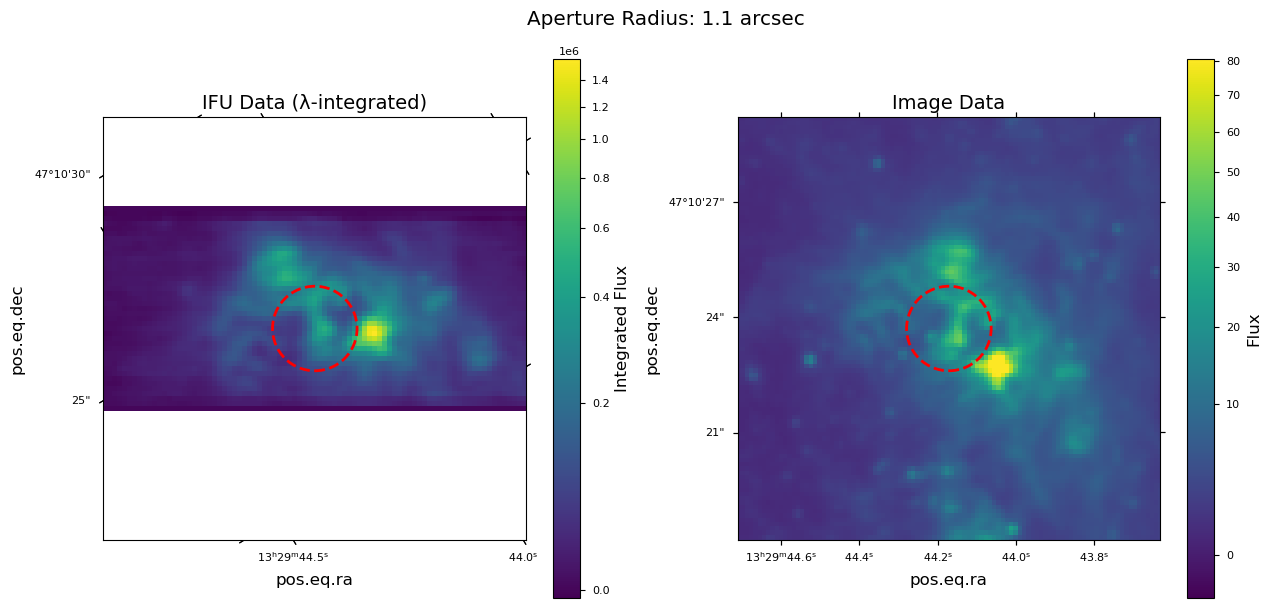

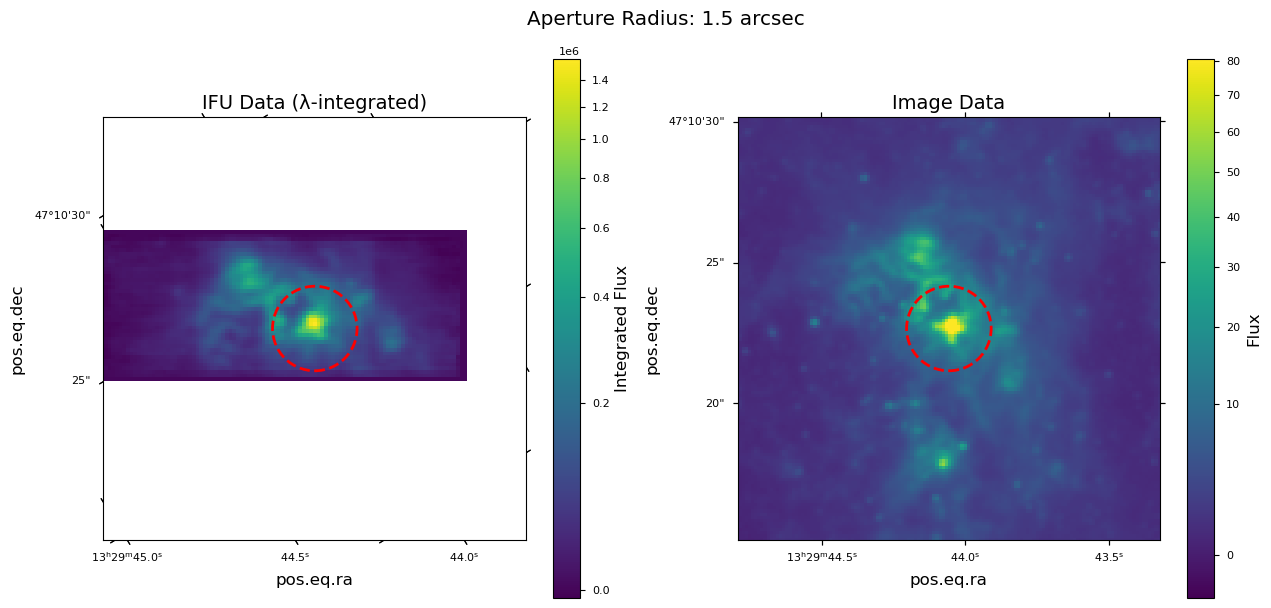

In [22]:
def plot_integrated_aperture_overlay(IFU_file, image_file, loc, radius, zoom_scale=5):
    """Display wavelength-integrated IFU data alongside 2D image."""
    from astropy.nddata import block_reduce
    
    def load_data(file):
        with fits.open(file) as hdul:
            for ext in [1, 'SCI', 0]:
                try:
                    data = hdul[ext].data
                    header = hdul[ext].header
                    if data is not None:
                        # Get 2D celestial WCS
                        wcs = WCS(header, naxis=2)
                        if data.ndim == 3:
                            # Sum over wavelength axis (axis=0)
                            integrated_data = np.nansum(data, axis=0)
                            return integrated_data, header, wcs
                        return data, header, wcs
                except (KeyError, IndexError):
                    continue
        raise ValueError(f"No valid data found in {file}")

    # Load and integrate IFU data
    ifu_integrated, ifu_header, ifu_wcs = load_data(IFU_file)
    image_data, image_header, image_wcs = load_data(image_file)
    # Convert location to pixels
    loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs')
    x_ifu, y_ifu = ifu_wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)
    x_img, y_img = image_wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)

    # Create figure
    fig = plt.figure(figsize=(15, 7))
    
    # Plot integrated IFU data
    ax1 = fig.add_subplot(121, projection=ifu_wcs)
    im1 = ax1.imshow(ifu_integrated, origin='lower', cmap='viridis',
                    norm=ImageNormalize(ifu_integrated, stretch=AsinhStretch(0.1)))
    fig.colorbar(im1, ax=ax1, label='Integrated Flux')
    ax1.set_title('IFU Data (λ-integrated)')

    # Plot Image
    ax2 = fig.add_subplot(122, projection=image_wcs)
    im2 = ax2.imshow(image_data, origin='lower', cmap='viridis',
                    norm=ImageNormalize(image_data/8, stretch=SqrtStretch()))
    fig.colorbar(im2, ax=ax2, label='Flux')
    ax2.set_title('Image Data')

    # Add apertures and set zoom
    for ax, (x, y), wcs in zip([ax1, ax2], [(x_ifu, y_ifu), (x_img, y_img)], [ifu_wcs, image_wcs]):
        pixel_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel
        radius_pix = radius.to(u.arcsec).value / pixel_scale
        ax.add_patch(Circle((x, y), radius_pix, ec='red', fc='none', lw=2, ls='--'))
        
        # Set zoom (5x aperture radius by default)
        zoom_width = zoom_scale * radius_pix
        ax.set_xlim(x - zoom_width, x + zoom_width)
        ax.set_ylim(y - zoom_width, y + zoom_width)
    
    plt.suptitle(f"Aperture Radius: {radius}", y=0.95)
    plt.tight_layout()
    plt.show()
image_file = [img for img in image_files if extract_filter_name(img).upper() == "F560W"][0]
IFU_file = 'Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits'
#[202.4340450, 47.1732517]
plot_integrated_aperture_overlay(IFU_file, image_file, loc, 1.1*u.arcsec)
plot_integrated_aperture_overlay(IFU_file, image_file, test_loc, 1.5*u.arcsec)

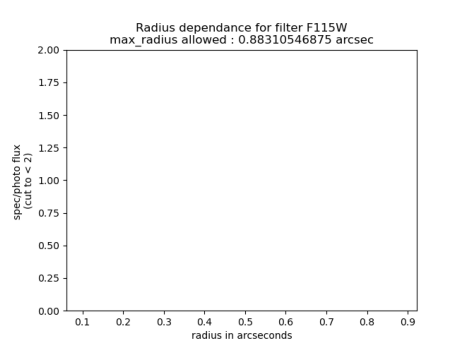

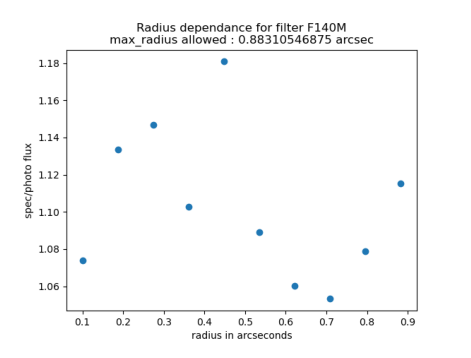

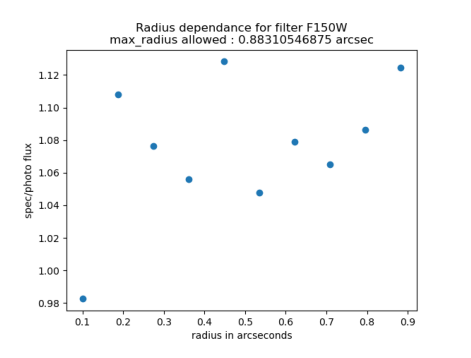

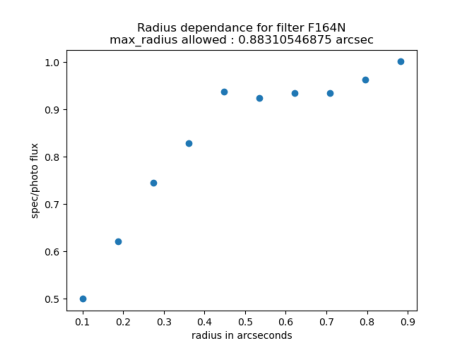

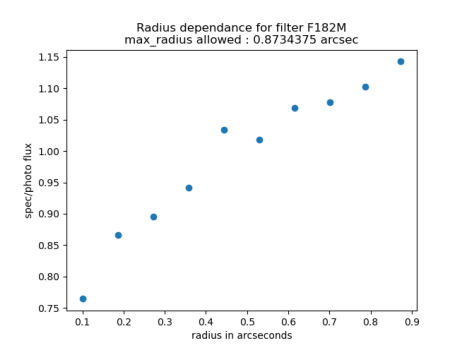

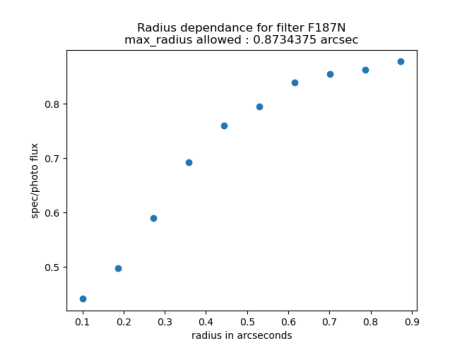

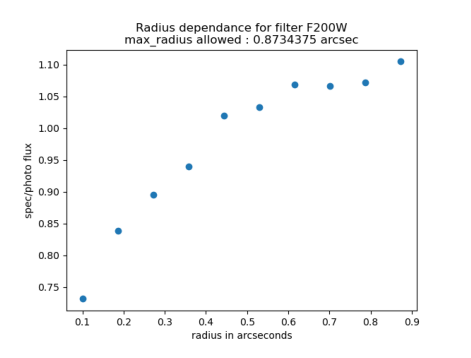

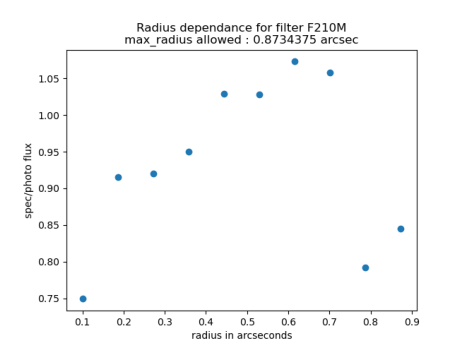

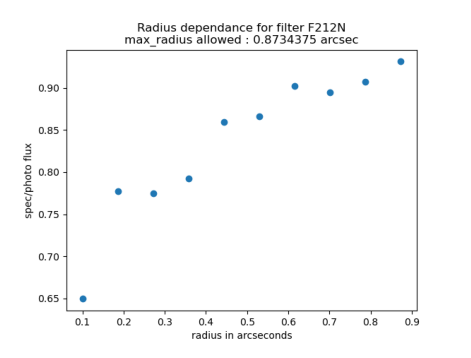

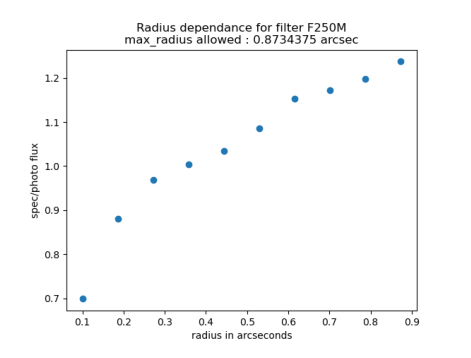

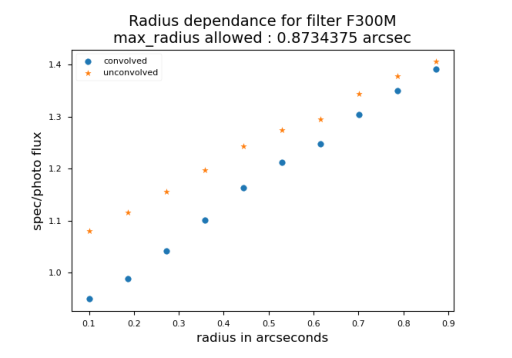

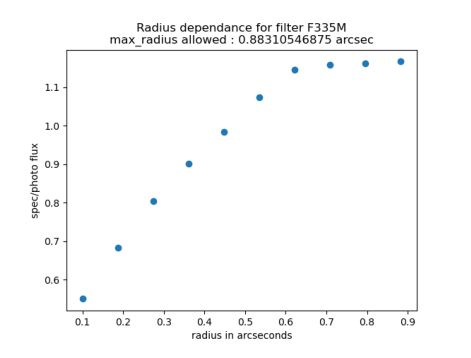

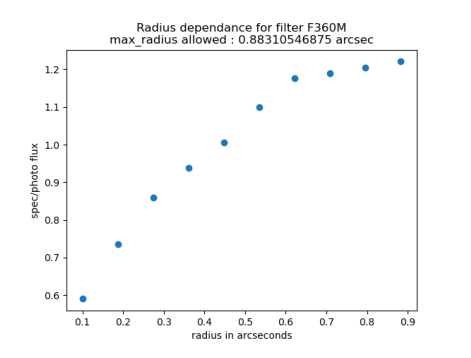

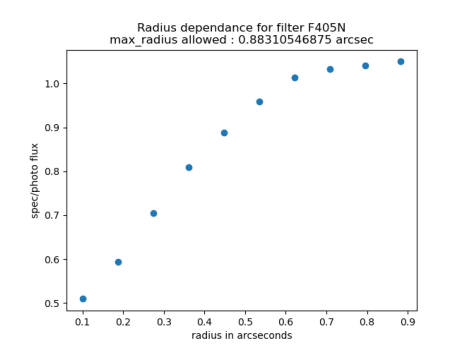

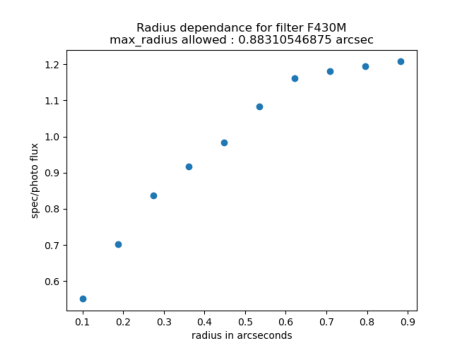

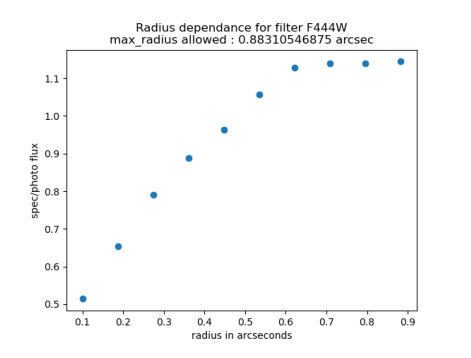

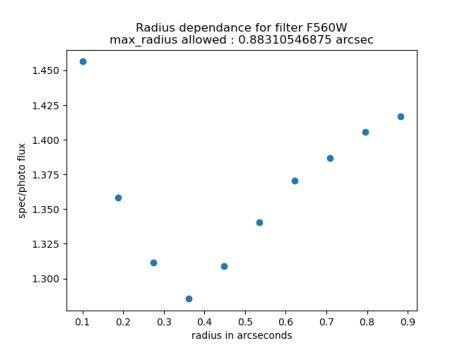

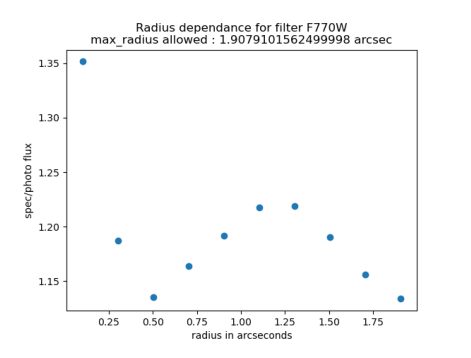

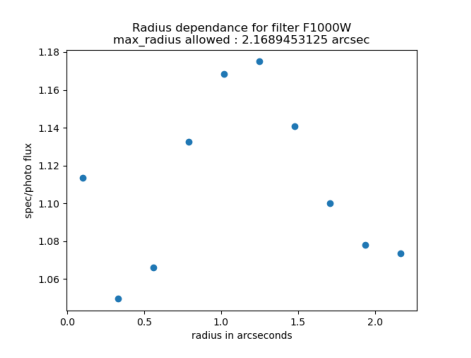

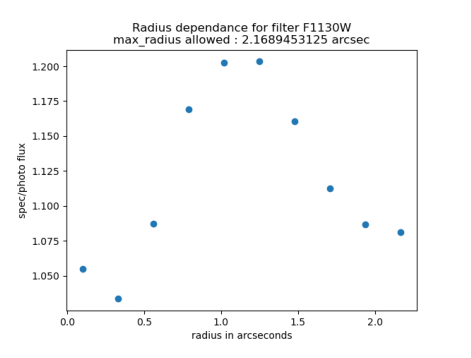

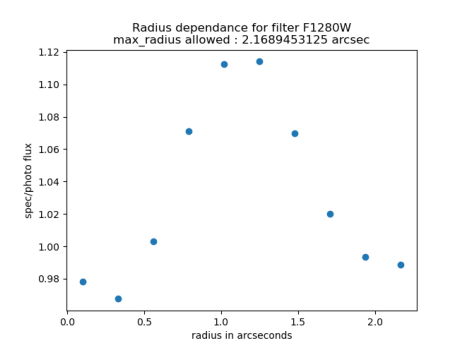

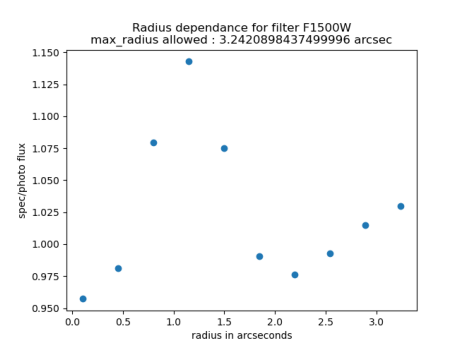

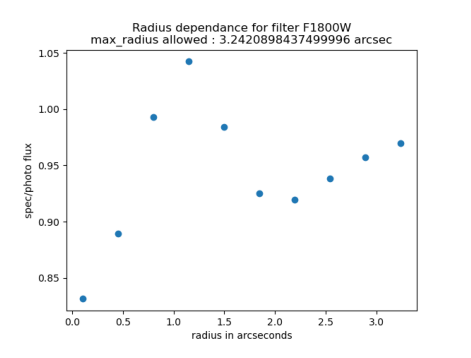

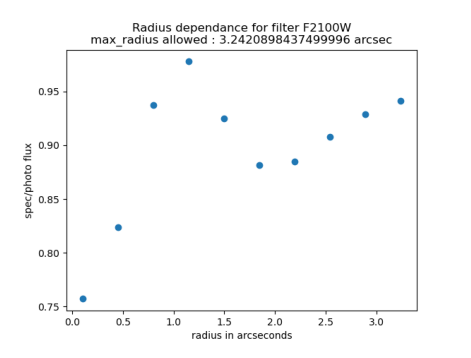

In [36]:
figure_files_unfiltered = glob.glob('Data_files/misc_data/misc_plots/*')
figure_files = [f for f in figure_files_unfiltered if f[-5:] != 't.png']

for file in figure_files:
    img = plt.imread(file)
    
    # Display it
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off axis labels
    plt.show()

In [36]:
def get_convolved_filter_name(file):
    '''Extracts "F115W" from 'Data_files/IFU_files/f100lp_s3dIFU_convolved_tof115w.fits'
    -------------
    
    Parameters
    -------------
    file : type = str - string of a convolved IFU

    Returns
    -------------
    filter_name : type = str - string with capital letters representing the filter name
    '''   
    return file.split("convolved_to")[1].split(".f")[0].upper()
needed_fits

array(['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
       'Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits'],
      dtype='<U77')

In [3]:
#TJ this cell compares Karin_reduction cubes to thomas reduction
image_flux = get_image_flux(image_files[15], loc, radius)
filter_name = extract_filter_name(filter_files[15]).upper()
filter_data = []
with open(filter_files[15], 'r') as f:
    header = f.readline().strip().split()
    for line in f:
        data_line = line.strip().split()
        filter_data.append(data_line)
        
header, filter_T = filter_data[:2], np.array(filter_data[2:])
filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
instrument = 'NIRCam'
#TJ commented out so the entire script can be re-run
#new_fits = convolve_filter(IFU_files[2], filter_name, output_file = f'Karin_reduction_convolved_to_F444W.fits')
new_fits = 'Data_files/IFU_files/Karin_reduction_convolved_to_F444W.fits'
spectrum = get_IFU_spectrum(new_fits, loc, radius, replace_negatives = 1e-1)
IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
print('Using karin_reduction: ', IFU_expected_flux/image_flux)

############################################

image_flux = get_image_flux(image_files[15], loc, radius)
filter_name = extract_filter_name(filter_files[15]).upper()
filter_data = []
with open(filter_files[15], 'r') as f:
    header = f.readline().strip().split()
    for line in f:
        data_line = line.strip().split()
        filter_data.append(data_line)
        
header, filter_T = filter_data[:2], np.array(filter_data[2:])
filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
instrument = 'NIRCam'
#TJ commented out so the entire script can be re-run
#new_fits = convolve_filter('Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits', filter_name, output_file = f'Thomas_reduction_convolved_to_F444W.fits')
new_fits = 'Data_files/IFU_files/Thomas_reduction_convolved_to_F444W.fits'
spectrum = get_IFU_spectrum(new_fits, loc, radius, replace_negatives = 1e-1)
IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
print('Using Thomas_reduction IFU for convolution: ', IFU_expected_flux/image_flux)


Using karin_reduction:  1.0408980105316208
Using Thomas_reduction IFU for convolution:  1.005944761494937


More than one IFU file is needed for filter f560w
1 nan values detected at wl: 5.269494898093397e-06 m within 0.1 arcsec aperture in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.2939499884532539e-31
This corresponds to a correction of 0.4617750152199815
Newly combined spectrum goes from 2.870894885563757e-06 to 7.650000025896587e-06
1 nan values detected at wl: 5.269494898093397e-06 m within 0.20957031250000002 arcsec aperture in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to

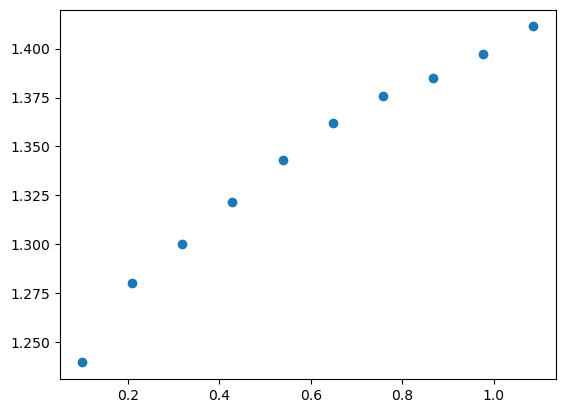

In [37]:
#THis cell checks the radius dependance of a single filter. For quick verifications
current_filter_name = 'F560W'
image_file = [img for img in image_files if extract_filter_name(img).upper() == current_filter_name][0]
needed_fits = which_fits(filter_files[-8], karin_SDuval_IFU_files) #TJ extract needed IFU files
filter_data = []
with open(filter_files[-8], 'r') as f:
    header = f.readline().strip().split()
    for line in f:
        data_line = line.strip().split()
        filter_data.append(data_line)

header, filter_T = filter_data[:2], np.array(filter_data[2:])
filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
max_R_candidates = []
for IFU_file in needed_fits:
    max_R_candidates.append(find_max_radius(IFU_file, image_file, test_loc)[0])
max_radius = min(max_R_candidates)
radii = np.linspace(0.1, max_radius.value, 10)
IFU_fluxes = []
for r in radii:
    radius = r*u.arcsec

    g_spectrum = stitch_spectra(needed_fits, test_loc, radius, replace_negatives = 0)
    g_photo_flux = get_image_flux(image_file, test_loc, radius)
    g_IFU_expected_flux = get_Fnu_transmission(g_spectrum["intensity"], g_spectrum["wavelength"], filter_trans, filter_wl)
    IFU_fluxes.append(g_IFU_expected_flux/g_photo_flux)
    #plot_integrated_aperture_overlay(needed_fits[0], image_file, loc, radius)

plt.scatter(radii, IFU_fluxes)


In [3]:
#TJ this cell doesnt need to be re-ran unless you want to recreate the convolved files, it should save the arrays at the end as well
#TJ THIS TAKES SEVERAL HOURS
'''
image_flux = []
karin_SDuval_IFU_flux = []
karin_IFU_flux = []
grant_flux = []
aperture_area_sr = np.pi * (radius.to(u.rad))**2
for file in filter_files:
    
    needed_fits = which_fits(file, karin_IFU_files) #TJ extract needed IFU files
    needed_karins = which_fits(file, karin_SDuval_IFU_files)
    needed_grants = which_fits(file, Grant_conv_IFU_files)
    print(f'for filter {extract_filter_name(file).upper()} we need: {needed_fits}')
    current_filter_name = extract_filter_name(file).upper()
    image_file = [img for img in image_files if extract_filter_name(img).upper() == current_filter_name][0]
    print(f'image file selected as {image_file}')
    photo_flux = (get_image_flux(image_file, loc, radius, replace_negatives=0))
    image_flux.append(photo_flux)

    
    filter_data = []
    with open(file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    
    if len(needed_fits)==1:
        IFU_file = needed_fits[0]
        instrument = 'NIRCam' if get_filter_number(current_filter_name) < 450 else "MIRI"
        new_fits = convolve_filter(IFU_file, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{extract_filter_name(file).upper()}.fits')
        spectrum = get_IFU_spectrum(new_fits, loc, radius, replace_negatives = 0)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        karin_SDuval_IFU_flux.append(IFU_expected_flux)
    else:
        new_fits = []
        for IFU_file in needed_fits:
            
            new_fits.append(convolve_filter(IFU_file, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{extract_filter_name(file).upper()}.fits'))
        
        spectrum = stitch_spectra(new_fits, loc, radius, replace_negatives=0)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        karin_SDuval_IFU_flux.append(IFU_expected_flux)

    if len(needed_karins)==1:
        IFU_file = needed_karins[0]
        instrument = 'NIRCam' if get_filter_number(current_filter_name) < 450 else "MIRI"
        new_fits = convolve_filter(IFU_file, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{extract_filter_name(file).upper()}.fits')
        spectrum = get_IFU_spectrum(new_fits, loc, radius, replace_negatives=0)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        karin_IFU_flux.append(IFU_expected_flux)
    else:
        new_fits = []
        for IFU_file in needed_karins:
            
            new_fits.append(convolve_filter(IFU_file, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{extract_filter_name(file).upper()}.fits'))
        
        spectrum = stitch_spectra(new_fits, loc, radius, replace_negatives=0)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        karin_IFU_flux.append(IFU_expected_flux)
        
    if len(needed_grants)==1:
        IFU_file = needed_grants[0]
        instrument = 'NIRCam' if get_filter_number(current_filter_name) < 450 else "MIRI"
        new_fits = convolve_filter(IFU_file, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{extract_filter_name(file).upper()}.fits')
        spectrum = get_IFU_spectrum(new_fits, loc, radius, replace_negatives=0)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        grant_flux.append(IFU_expected_flux)
    else:
        new_fits = []
        for IFU_file in needed_karins:
            
            new_fits.append(convolve_filter(IFU_file, extract_filter_name(file).upper(), output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{extract_filter_name(file).upper()}.fits'))
        
        spectrum = stitch_spectra(new_fits, loc, radius, replace_negatives=0)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        grant_flux.append(IFU_expected_flux)


karin_SDuval_IFU_flux = np.array(karin_SDuval_IFU_flux)
karin_IFU_flux = np.array(karin_IFU_flux)
grant_flux = np.array(grant_flux)
image_flux = np.array(image_flux)
np.save('Data_files/misc_data/Karin_SDuval_IFU_expected_flux.npy', karin_SDuval_IFU_flux)
np.save('Data_files/misc_data/Karin_IFU_expected_flux.npy', karin_IFU_flux)
np.save('Data_files/misc_data/Image_fluxes.npy', image_flux)
np.save('Data_files/misc_data/Grant_IFU_expected_flux.npy', grant_flux)
'''
print()


for filter F115W we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f115w_i2d.fits
cube was cut to be 9.887620289518963e-07 m to 1.3283860351366452e-06 m. Filter is from 9.892e-07 m to 1.3282e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 0.9887620289518964 um to 1.3283860351366452 um


Convolving to F115W:   0%|          | 0/535 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF115W.fits
cube was cut to be 9.887620289518963e-07 m to 1.3283860351366452e-06 m. Filter is from 9.892e-07 m to 1.3282e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 0.9887620289518964 um to 1.3283860351366452 um


Convolving to F115W:   0%|          | 0/535 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF115W.fits
cube was cut to be 9.887620289518963e-07 m to 1.3283860351366452e-06 m. Filter is from 9.892e-07 m to 1.3282e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 0.9887620289518964 um to 1.3283860351366452 um


Convolving to F115W:   0%|          | 0/535 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1_convolved_toF115W.fits
for filter F140M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f140m_i2d.fits
cube was cut to be 1.2819580342911644e-06 m to 1.5363580389239351e-06 m. Filter is from 1.28235e-06 m to 1.5363500000000001e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2819580342911645 um to 1.5363580389239353 um


Convolving to F140M:   0%|          | 0/401 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF140M.fits
cube was cut to be 1.2819580342911644e-06 m to 1.5363580389239351e-06 m. Filter is from 1.28235e-06 m to 1.5363500000000001e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2819580342911645 um to 1.5363580389239353 um


Convolving to F140M:   0%|          | 0/401 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF140M.fits
cube was cut to be 1.2819580342911644e-06 m to 1.5363580389239351e-06 m. Filter is from 1.28235e-06 m to 1.5363500000000001e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2819580342911645 um to 1.5363580389239353 um


Convolving to F140M:   0%|          | 0/401 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1_convolved_toF140M.fits
for filter F150W we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f150w_i2d.fits
cube was cut to be 1.2794140342448366e-06 m to 1.723978042340604e-06 m. Filter is from 1.27979e-06 m to 1.7237900000000003e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2794140342448368 um to 1.723978042340604 um


Convolving to F150W:   0%|          | 0/700 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF150W.fits
cube was cut to be 1.2794140342448366e-06 m to 1.723978042340604e-06 m. Filter is from 1.27979e-06 m to 1.7237900000000003e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2794140342448368 um to 1.723978042340604 um


Convolving to F150W:   0%|          | 0/700 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF150W.fits
cube was cut to be 1.2794140342448366e-06 m to 1.723978042340604e-06 m. Filter is from 1.27979e-06 m to 1.7237900000000003e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2794140342448368 um to 1.723978042340604 um


Convolving to F150W:   0%|          | 0/700 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1_convolved_toF150W.fits
for filter F164N we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f164n_i2d.fits
cube was cut to be 1.6088620402442749e-06 m to 1.6807300415530328e-06 m. Filter is from 1.6094e-06 m to 1.6804e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.608862040244275 um to 1.6807300415530328 um


Convolving to F164N:   0%|          | 0/114 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF164N.fits
cube was cut to be 1.6088620402442749e-06 m to 1.6807300415530328e-06 m. Filter is from 1.6094e-06 m to 1.6804e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.608862040244275 um to 1.6807300415530328 um


Convolving to F164N:   0%|          | 0/114 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF164N.fits
cube was cut to be 1.6088620402442749e-06 m to 1.6807300415530328e-06 m. Filter is from 1.6094e-06 m to 1.6804e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.608862040244275 um to 1.6807300415530328 um


Convolving to F164N:   0%|          | 0/114 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1_convolved_toF164N.fits
for filter F182M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f182m_i2d.fits
cube was cut to be 1.662649966718163e-06 m to 2.0453099806909446e-06 m. Filter is from 1.6635e-06 m to 2.0445e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.6626499667181631 um to 2.0453099806909445 um


Convolving to F182M:   0%|          | 0/362 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF182M.fits
cube was cut to be 1.662649966718163e-06 m to 2.0453099806909446e-06 m. Filter is from 1.6635e-06 m to 2.0445e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.6626499667181631 um to 2.0453099806909445 um


Convolving to F182M:   0%|          | 0/362 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF182M.fits
cube was cut to be 1.662649966718163e-06 m to 2.0453099806909446e-06 m. Filter is from 1.6635e-06 m to 2.0445e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.6626499667181631 um to 2.0453099806909445 um


Convolving to F182M:   0%|          | 0/362 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1_convolved_toF182M.fits
for filter F187N we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f187n_i2d.fits
cube was cut to be 1.8333099729497916e-06 m to 1.91386997589143e-06 m. Filter is from 1.8342000000000002e-06 m to 1.9132e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.8333099729497917 um to 1.9138699758914297 um


Convolving to F187N:   0%|          | 0/77 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF187N.fits
cube was cut to be 1.8333099729497916e-06 m to 1.91386997589143e-06 m. Filter is from 1.8342000000000002e-06 m to 1.9132e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.8333099729497917 um to 1.9138699758914297 um


Convolving to F187N:   0%|          | 0/77 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF187N.fits
cube was cut to be 1.8333099729497916e-06 m to 1.91386997589143e-06 m. Filter is from 1.8342000000000002e-06 m to 1.9132e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.8333099729497917 um to 1.9138699758914297 um


Convolving to F187N:   0%|          | 0/77 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1_convolved_toF187N.fits
for filter F200W we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f200w_i2d.fits
cube was cut to be 1.6902099677245132e-06 m to 2.2986499899416227e-06 m. Filter is from 1.6904000000000002e-06 m to 2.2984e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.6902099677245133 um to 2.2986499899416226 um


Convolving to F200W:   0%|          | 0/575 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF200W.fits
cube was cut to be 1.6902099677245132e-06 m to 2.2986499899416227e-06 m. Filter is from 1.6904000000000002e-06 m to 2.2984e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.6902099677245133 um to 2.2986499899416226 um


Convolving to F200W:   0%|          | 0/575 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF200W.fits
cube was cut to be 1.6902099677245132e-06 m to 2.2986499899416227e-06 m. Filter is from 1.6904000000000002e-06 m to 2.2984e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.6902099677245133 um to 2.2986499899416226 um


Convolving to F200W:   0%|          | 0/575 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1_convolved_toF200W.fits
for filter F210M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f210m_i2d.fits
cube was cut to be 1.930829976510722e-06 m to 2.2657899887417443e-06 m. Filter is from 1.9316000000000003e-06 m to 2.2656e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.930829976510722 um to 2.2657899887417443 um


Convolving to F210M:   0%|          | 0/317 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF210M.fits
cube was cut to be 1.930829976510722e-06 m to 2.2657899887417443e-06 m. Filter is from 1.9316000000000003e-06 m to 2.2656e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.930829976510722 um to 2.2657899887417443 um


Convolving to F210M:   0%|          | 0/317 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF210M.fits
cube was cut to be 1.930829976510722e-06 m to 2.2657899887417443e-06 m. Filter is from 1.9316000000000003e-06 m to 2.2656e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 1.930829976510722 um to 2.2657899887417443 um


Convolving to F210M:   0%|          | 0/317 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1_convolved_toF210M.fits
for filter F212N we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f212n_i2d.fits
cube was cut to be 2.0792299819295295e-06 m to 2.1640299850259906e-06 m. Filter is from 2.0793e-06 m to 2.1633e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 2.0792299819295295 um to 2.1640299850259908 um


Convolving to F212N:   0%|          | 0/81 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF212N.fits
cube was cut to be 2.0792299819295295e-06 m to 2.1640299850259906e-06 m. Filter is from 2.0793e-06 m to 2.1633e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 2.0792299819295295 um to 2.1640299850259908 um


Convolving to F212N:   0%|          | 0/81 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF212N.fits
cube was cut to be 2.0792299819295295e-06 m to 2.1640299850259906e-06 m. Filter is from 2.0793e-06 m to 2.1633e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 2.0792299819295295 um to 2.1640299850259908 um


Convolving to F212N:   0%|          | 0/81 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1_convolved_toF212N.fits
for filter F250M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f250m_i2d.fits
cube was cut to be 2.374969992728438e-06 m to 2.6569300030241714e-06 m. Filter is from 2.37551e-06 m to 2.65654e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 2.374969992728438 um to 2.6569300030241716 um


Convolving to F250M:   0%|          | 0/267 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF250M.fits
cube was cut to be 2.374969992728438e-06 m to 2.6569300030241714e-06 m. Filter is from 2.37551e-06 m to 2.65654e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 2.374969992728438 um to 2.6569300030241716 um


Convolving to F250M:   0%|          | 0/267 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF250M.fits
cube was cut to be 2.374969992728438e-06 m to 2.6569300030241714e-06 m. Filter is from 2.37551e-06 m to 2.65654e-06 m
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes from 2.374969992728438 um to 2.6569300030241716 um


Convolving to F250M:   0%|          | 0/267 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1_convolved_toF250M.fits
More than one IFU file is needed for filter f300m
More than one IFU file is needed for filter f300m
More than one IFU file is needed for filter f300m
for filter F300M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits', 'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f300m_i2d.fits
cube was cut to be 2.7003900046111078e-06 m to 3.1699700217577617e-06 m. Filter is from 2.70111e-06 m to 3.31457e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits
  Filter F300M requires: 2.70111e-06-3.31457e-06 meters
  Cube provides: 1.6605299666407517e-06-3.1699700217577617e-06 meters
  Missing ranges:
- Missing long wavelengths: 3.1699700217577617e-06 m-3.31457e-06 m μm
  Using available range: 

Convolving to F300M:   0%|          | 0/444 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF300M.fits
cube was cut to be 2.870894885563757e-06 m to 3.3148148878826756e-06 m. Filter is from 2.70111e-06 m to 3.31457e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
  Filter F300M requires: 2.70111e-06-3.31457e-06 meters
  Cube provides: 2.870894885563757e-06-5.2694948980933964e-06 meters
  Missing ranges:
- Missing short wavelengths: 2.70111e-06 m-2.870894885563757e-06 m μm
  Using available range: 2.870894885563757e-06-3.3148148878826756e-06 meters
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 2.8708948855637573 um to 3.3148148878826755 um


Convolving to F300M:   0%|          | 0/249 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF300M.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.986750370999291e-30
This corresponds to a correction of 0.0777691382467705
Newly combined spectrum goes from 2.7003900046111e-06 to 3.314814887882724e-06
cube was cut to be 2.7003900046111078e-06 m to 3.1699700217577617e-06 m. Filter is from 2.70111e-06 m to 3.31457e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits
  Filter F300M requires: 2.70111e-06-3.31457e-06 meters
  Cube provides: 1.6605299666407517e-06-3.1699700217577617e-06 meters
  Missing ranges:
- Missing long wavelengths: 3.1699700217577617e-06 m-3.31457e-06 m μm
  Using available range: 2.7003900046111078e-06-3.1699700217577617e-06 meters
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes 

Convolving to F300M:   0%|          | 0/444 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF300M.fits
cube was cut to be 2.870894885563757e-06 m to 3.3148148878826756e-06 m. Filter is from 2.70111e-06 m to 3.31457e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
  Filter F300M requires: 2.70111e-06-3.31457e-06 meters
  Cube provides: 2.870894885563757e-06-5.2694948980933964e-06 meters
  Missing ranges:
- Missing short wavelengths: 2.70111e-06 m-2.870894885563757e-06 m μm
  Using available range: 2.870894885563757e-06-3.3148148878826756e-06 meters
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 2.8708948855637573 um to 3.3148148878826755 um


Convolving to F300M:   0%|          | 0/249 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF300M.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.986750370999291e-30
This corresponds to a correction of 0.0777691382467705
Newly combined spectrum goes from 2.7003900046111e-06 to 3.314814887882724e-06
cube was cut to be 2.7003900046111078e-06 m to 3.1699700217577617e-06 m. Filter is from 2.70111e-06 m to 3.31457e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits
  Filter F300M requires: 2.70111e-06-3.31457e-06 meters
  Cube provides: 1.6605299666407517e-06-3.1699700217577617e-06 meters
  Missing ranges:
- Missing long wavelengths: 3.1699700217577617e-06 m-3.31457e-06 m μm
  Using available range: 2.7003900046111078e-06-3.1699700217577617e-06 meters
prior to cut : cube goes from 1.6605299666407518 um to 3.169970021757762 um
after cut : cube goes 

Convolving to F300M:   0%|          | 0/444 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF300M.fits
cube was cut to be 2.870894885563757e-06 m to 3.3148148878826756e-06 m. Filter is from 2.70111e-06 m to 3.31457e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
  Filter F300M requires: 2.70111e-06-3.31457e-06 meters
  Cube provides: 2.870894885563757e-06-5.2694948980933964e-06 meters
  Missing ranges:
- Missing short wavelengths: 2.70111e-06 m-2.870894885563757e-06 m μm
  Using available range: 2.870894885563757e-06-3.3148148878826756e-06 meters
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 2.8708948855637573 um to 3.3148148878826755 um


Convolving to F300M:   0%|          | 0/249 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF300M.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.986750370999291e-30
This corresponds to a correction of 0.0777691382467705
Newly combined spectrum goes from 2.7003900046111e-06 to 3.314814887882724e-06
for filter F335M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f335m_i2d.fits
cube was cut to be 3.026624886377249e-06 m to 3.7802148903137993e-06 m. Filter is from 3.02811e-06 m to 3.7793900000000003e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.026624886377249 um to 3.7802148903137995 um


Convolving to F335M:   0%|          | 0/422 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF335M.fits
cube was cut to be 3.026624886377249e-06 m to 3.7802148903137993e-06 m. Filter is from 3.02811e-06 m to 3.7793900000000003e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.026624886377249 um to 3.7802148903137995 um


Convolving to F335M:   0%|          | 0/422 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF335M.fits
cube was cut to be 3.026624886377249e-06 m to 3.7802148903137993e-06 m. Filter is from 3.02811e-06 m to 3.7793900000000003e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.026624886377249 um to 3.7802148903137995 um


Convolving to F335M:   0%|          | 0/422 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1_convolved_toF335M.fits
for filter F360M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f360m_i2d.fits
cube was cut to be 3.2414248874993058e-06 m to 3.989644891407806e-06 m. Filter is from 3.24296e-06 m to 3.98884e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.241424887499306 um to 3.989644891407806 um


Convolving to F360M:   0%|          | 0/419 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF360M.fits
cube was cut to be 3.2414248874993058e-06 m to 3.989644891407806e-06 m. Filter is from 3.24296e-06 m to 3.98884e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.241424887499306 um to 3.989644891407806 um


Convolving to F360M:   0%|          | 0/419 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF360M.fits
cube was cut to be 3.2414248874993058e-06 m to 3.989644891407806e-06 m. Filter is from 3.24296e-06 m to 3.98884e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.241424887499306 um to 3.989644891407806 um


Convolving to F360M:   0%|          | 0/419 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1_convolved_toF360M.fits
for filter F405N we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f405n_i2d.fits
cube was cut to be 3.9681648912956e-06 m to 4.1364248921745455e-06 m. Filter is from 3.96992e-06 m to 4.13612e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.9681648912956002 um to 4.136424892174546 um


Convolving to F405N:   0%|          | 0/95 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF405N.fits
cube was cut to be 3.9681648912956e-06 m to 4.1364248921745455e-06 m. Filter is from 3.96992e-06 m to 4.13612e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.9681648912956002 um to 4.136424892174546 um


Convolving to F405N:   0%|          | 0/95 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF405N.fits
cube was cut to be 3.9681648912956e-06 m to 4.1364248921745455e-06 m. Filter is from 3.96992e-06 m to 4.13612e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.9681648912956002 um to 4.136424892174546 um


Convolving to F405N:   0%|          | 0/95 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1_convolved_toF405N.fits
for filter F430M we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f430m_i2d.fits
cube was cut to be 4.063034891791176e-06 m to 4.510534894128795e-06 m. Filter is from 4.0645e-06 m to 4.51041e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 4.063034891791176 um to 4.510534894128795 um


Convolving to F430M:   0%|          | 0/251 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF430M.fits
cube was cut to be 4.063034891791176e-06 m to 4.510534894128795e-06 m. Filter is from 4.0645e-06 m to 4.51041e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 4.063034891791176 um to 4.510534894128795 um


Convolving to F430M:   0%|          | 0/251 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF430M.fits
cube was cut to be 4.063034891791176e-06 m to 4.510534894128795e-06 m. Filter is from 4.0645e-06 m to 4.51041e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 4.063034891791176 um to 4.510534894128795 um


Convolving to F430M:   0%|          | 0/251 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1_convolved_toF430M.fits
for filter F444W we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_nircam_lv3_f444w_i2d.fits
cube was cut to be 3.712194889958481e-06 m to 5.101234897214453e-06 m. Filter is from 3.7131800000000006e-06 m to 5.09955e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.7121948899584813 um to 5.101234897214453 um


Convolving to F444W:   0%|          | 0/777 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF444W.fits
cube was cut to be 3.712194889958481e-06 m to 5.101234897214453e-06 m. Filter is from 3.7131800000000006e-06 m to 5.09955e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.7121948899584813 um to 5.101234897214453 um


Convolving to F444W:   0%|          | 0/777 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF444W.fits
cube was cut to be 3.712194889958481e-06 m to 5.101234897214453e-06 m. Filter is from 3.7131800000000006e-06 m to 5.09955e-06 m
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 3.7121948899584813 um to 5.101234897214453 um


Convolving to F444W:   0%|          | 0/777 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1_convolved_toF444W.fits
More than one IFU file is needed for filter f560w
More than one IFU file is needed for filter f560w
More than one IFU file is needed for filter f560w
for filter F560W we need: ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits', 'Data_files/IFU_files/Arm2_Level3_ch1-shortmediumlong_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_miri_lv3_f560w_i2d.fits
cube was cut to be 4.752184895391109e-06 m to 5.2694948980933964e-06 m. Filter is from 4.753e-06 m to 6.696e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
  Filter F560W requires: 4.753e-06-6.696e-06 meters
  Cube provides: 2.870894885563757e-06-5.2694948980933964e-06 meters
  Missing ranges:
- Missing long wavelengths: 5.2694948980933964e-06 m-6.696e-06 m μm
  Using available range: 4.752184895391109e-06-5.269494

Convolving to F560W:   0%|          | 0/290 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF560W.fits
cube was cut to be 4.9004000953573265e-06 m to 6.696400049986549e-06 m. Filter is from 4.753e-06 m to 6.696e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch1-shortmediumlong_s3d.fits
  Filter F560W requires: 4.753e-06-6.696e-06 meters
  Cube provides: 4.9004000953573265e-06-7.650000025896587e-06 meters
  Missing ranges:
- Missing short wavelengths: 4.753e-06 m-4.9004000953573265e-06 m μm
  Using available range: 4.9004000953573265e-06-6.696400049986549e-06 meters
prior to cut : cube goes from 4.900400095357327 um to 7.650000025896587 um
after cut : cube goes from 4.900400095357327 um to 6.69640004998655 um


Convolving to F560W:   0%|          | 0/2246 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch1-shortmediumlong_s3d_convolved_toF560W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.3514570605987889e-30
This corresponds to a correction of 0.03088359500559968
Newly combined spectrum goes from 4.7521848953911e-06 to 6.696400049986524e-06
cube was cut to be 4.752184895391109e-06 m to 5.2694948980933964e-06 m. Filter is from 4.753e-06 m to 6.696e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
  Filter F560W requires: 4.753e-06-6.696e-06 meters
  Cube provides: 2.870894885563757e-06-5.2694948980933964e-06 meters
  Missing ranges:
- Missing long wavelengths: 5.2694948980933964e-06 m-6.696e-06 m μm
  Using available range: 4.752184895391109e-06-5.2694948980933964e-06 meters
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 4.75218489539

Convolving to F560W:   0%|          | 0/290 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF560W.fits
cube was cut to be 4.9004000953573265e-06 m to 6.696400049986549e-06 m. Filter is from 4.753e-06 m to 6.696e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits
  Filter F560W requires: 4.753e-06-6.696e-06 meters
  Cube provides: 4.9004000953573265e-06-7.650000025896587e-06 meters
  Missing ranges:
- Missing short wavelengths: 4.753e-06 m-4.9004000953573265e-06 m μm
  Using available range: 4.9004000953573265e-06-6.696400049986549e-06 meters
prior to cut : cube goes from 4.900400095357327 um to 7.650000025896587 um
after cut : cube goes from 4.900400095357327 um to 6.69640004998655 um


Convolving to F560W:   0%|          | 0/2246 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch1-shortmediumlong_s3d_convolved_toF560W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 4.94787705440075e-30
This corresponds to a correction of 0.12006036439163659
Newly combined spectrum goes from 4.7521848953911e-06 to 6.696400049986524e-06
cube was cut to be 4.752184895391109e-06 m to 5.2694948980933964e-06 m. Filter is from 4.753e-06 m to 6.696e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
  Filter F560W requires: 4.753e-06-6.696e-06 meters
  Cube provides: 2.870894885563757e-06-5.2694948980933964e-06 meters
  Missing ranges:
- Missing long wavelengths: 5.2694948980933964e-06 m-6.696e-06 m μm
  Using available range: 4.752184895391109e-06-5.2694948980933964e-06 meters
prior to cut : cube goes from 2.8708948855637573 um to 5.269494898093397 um
after cut : cube goes from 4.752184895391109 um

Convolving to F560W:   0%|          | 0/290 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF560W.fits
cube was cut to be 4.9004000953573265e-06 m to 6.696400049986549e-06 m. Filter is from 4.753e-06 m to 6.696e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits
  Filter F560W requires: 4.753e-06-6.696e-06 meters
  Cube provides: 4.9004000953573265e-06-7.650000025896587e-06 meters
  Missing ranges:
- Missing short wavelengths: 4.753e-06 m-4.9004000953573265e-06 m μm
  Using available range: 4.9004000953573265e-06-6.696400049986549e-06 meters
prior to cut : cube goes from 4.900400095357327 um to 7.650000025896587 um
after cut : cube goes from 4.900400095357327 um to 6.69640004998655 um


Convolving to F560W:   0%|          | 0/2246 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch1-shortmediumlong_s3d_convolved_toF560W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 4.94787705440075e-30
This corresponds to a correction of 0.12006036439163659
Newly combined spectrum goes from 4.7521848953911e-06 to 6.696400049986524e-06
More than one IFU file is needed for filter f770w
More than one IFU file is needed for filter f770w
More than one IFU file is needed for filter f770w
for filter F770W we need: ['Data_files/IFU_files/Arm2_Level3_ch1-shortmediumlong_s3d.fits', 'Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_miri_lv3_f770w_i2d.fits
cube was cut to be 6.207600062334676e-06 m to 7.650000025896587e-06 m. Filter is from 6.2080000000000005e-06 m to 9.329e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch1-shortmediumlong_s3d.fits
  Filter F770W requires: 6

Convolving to F770W:   0%|          | 0/1804 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch1-shortmediumlong_s3d_convolved_toF770W.fits
cube was cut to be 7.5106502288836055e-06 m to 9.3293502338347e-06 m. Filter is from 6.2080000000000005e-06 m to 9.329e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits
  Filter F770W requires: 6.2080000000000005e-06-9.329e-06 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing short wavelengths: 6.2080000000000005e-06 m-7.5106502288836055e-06 m μm
  Using available range: 7.5106502288836055e-06-9.3293502338347e-06 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 7.5106502288836055 um to 9.3293502338347 um


Convolving to F770W:   0%|          | 0/1400 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch2-shortmediumlong_s3d_convolved_toF770W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 9.595540819473937e-30
This corresponds to a correction of 0.008159904796989019
Newly combined spectrum goes from 6.2076000623347e-06 to 9.32935023383466e-06
cube was cut to be 6.207600062334676e-06 m to 7.650000025896587e-06 m. Filter is from 6.2080000000000005e-06 m to 9.329e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits
  Filter F770W requires: 6.2080000000000005e-06-9.329e-06 meters
  Cube provides: 4.9004000953573265e-06-7.650000025896587e-06 meters
  Missing ranges:
- Missing long wavelengths: 7.650000025896587e-06 m-9.329e-06 m μm
  Using available range: 6.207600062334676e-06-7.650000025896587e-06 meters
prior to cut : cube goes from 4.900400095357327 um to 7.650000025896587 um
after cut : cube goes from 6.20

Convolving to F770W:   0%|          | 0/1804 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch1-shortmediumlong_s3d_convolved_toF770W.fits
cube was cut to be 7.5106502288836055e-06 m to 9.3293502338347e-06 m. Filter is from 6.2080000000000005e-06 m to 9.329e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits
  Filter F770W requires: 6.2080000000000005e-06-9.329e-06 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing short wavelengths: 6.2080000000000005e-06 m-7.5106502288836055e-06 m μm
  Using available range: 7.5106502288836055e-06-9.3293502338347e-06 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 7.5106502288836055 um to 9.3293502338347 um


Convolving to F770W:   0%|          | 0/1400 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF770W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.0760516901657585e-29
This corresponds to a correction of 0.009436966580394134
Newly combined spectrum goes from 6.2076000623347e-06 to 9.32935023383466e-06
cube was cut to be 6.207600062334676e-06 m to 7.650000025896587e-06 m. Filter is from 6.2080000000000005e-06 m to 9.329e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits
  Filter F770W requires: 6.2080000000000005e-06-9.329e-06 meters
  Cube provides: 4.9004000953573265e-06-7.650000025896587e-06 meters
  Missing ranges:
- Missing long wavelengths: 7.650000025896587e-06 m-9.329e-06 m μm
  Using available range: 6.207600062334676e-06-7.650000025896587e-06 meters
prior to cut : cube goes from 4.900400095357327 um to 7.650000025896587 um
after cut : cube goes from 6.207600

Convolving to F770W:   0%|          | 0/1804 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch1-shortmediumlong_s3d_convolved_toF770W.fits
cube was cut to be 7.5106502288836055e-06 m to 9.3293502338347e-06 m. Filter is from 6.2080000000000005e-06 m to 9.329e-06 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits
  Filter F770W requires: 6.2080000000000005e-06-9.329e-06 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing short wavelengths: 6.2080000000000005e-06 m-7.5106502288836055e-06 m μm
  Using available range: 7.5106502288836055e-06-9.3293502338347e-06 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 7.5106502288836055 um to 9.3293502338347 um


Convolving to F770W:   0%|          | 0/1400 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF770W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.0760516901657585e-29
This corresponds to a correction of 0.009436966580394134
Newly combined spectrum goes from 6.2076000623347e-06 to 9.32935023383466e-06
for filter F1000W we need: ['Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_miri_lv3_f1000w_i2d.fits
cube was cut to be 8.74175023223506e-06 m to 1.151595023978734e-05 m. Filter is from 8.743e-06 m to 1.1515e-05 m
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 8.741750232235061 um to 11.515950239787342 um


Convolving to F1000W:   0%|          | 0/2135 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch2-shortmediumlong_s3d_convolved_toF1000W.fits
cube was cut to be 8.74175023223506e-06 m to 1.151595023978734e-05 m. Filter is from 8.743e-06 m to 1.1515e-05 m
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 8.741750232235061 um to 11.515950239787342 um


Convolving to F1000W:   0%|          | 0/2135 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF1000W.fits
cube was cut to be 8.74175023223506e-06 m to 1.151595023978734e-05 m. Filter is from 8.743e-06 m to 1.1515e-05 m
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 8.741750232235061 um to 11.515950239787342 um


Convolving to F1000W:   0%|          | 0/2135 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_conv17p1um_convolved_toF1000W.fits
More than one IFU file is needed for filter f1130w
More than one IFU file is needed for filter f1130w
More than one IFU file is needed for filter f1130w
for filter F1130W we need: ['Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits', 'Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_miri_lv3_f1130w_i2d.fits
cube was cut to be 1.024975023634033e-05 m to 1.1700550240289882e-05 m. Filter is from 1.0251e-05 m to 1.2229000000000001e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits
  Filter F1130W requires: 1.0251e-05-1.2229000000000001e-05 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing long wavelengths: 1.1700550240289882e-05 m-1.2229000000000001e-05 m μm
  Using available range: 1.024975023634033e-05-1

Convolving to F1130W:   0%|          | 0/1117 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch2-shortmediumlong_s3d_convolved_toF1130W.fits
cube was cut to be 1.155125019070692e-05 m to 1.2231250175507736e-05 m. Filter is from 1.0251e-05 m to 1.2229000000000001e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits
  Filter F1130W requires: 1.0251e-05-1.2229000000000001e-05 meters
  Cube provides: 1.155125019070692e-05-1.7978750047041097e-05 meters
  Missing ranges:
- Missing short wavelengths: 1.0251e-05 m-1.155125019070692e-05 m μm
  Using available range: 1.155125019070692e-05-1.2231250175507736e-05 meters
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 11.551250190706922 um to 12.231250175507737 um


Convolving to F1130W:   0%|          | 0/273 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch3-shortmediumlong_s3d_convolved_toF1130W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 3.3808655081094763e-29
This corresponds to a correction of 0.07372555482447318
Newly combined spectrum goes from 1.024975023634e-05 to 1.2231250175507804e-05
cube was cut to be 1.024975023634033e-05 m to 1.1700550240289882e-05 m. Filter is from 1.0251e-05 m to 1.2229000000000001e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits
  Filter F1130W requires: 1.0251e-05-1.2229000000000001e-05 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing long wavelengths: 1.1700550240289882e-05 m-1.2229000000000001e-05 m μm
  Using available range: 1.024975023634033e-05-1.1700550240289882e-05 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after c

Convolving to F1130W:   0%|          | 0/1117 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF1130W.fits
cube was cut to be 1.155125019070692e-05 m to 1.2231250175507736e-05 m. Filter is from 1.0251e-05 m to 1.2229000000000001e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits
  Filter F1130W requires: 1.0251e-05-1.2229000000000001e-05 meters
  Cube provides: 1.155125019070692e-05-1.7978750047041097e-05 meters
  Missing ranges:
- Missing short wavelengths: 1.0251e-05 m-1.155125019070692e-05 m μm
  Using available range: 1.155125019070692e-05-1.2231250175507736e-05 meters
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 11.551250190706922 um to 12.231250175507737 um


Convolving to F1130W:   0%|          | 0/273 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch3-shortmediumlong_s3d_convolved_toF1130W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.89842976359925e-29
This corresponds to a correction of -0.03945300792356956
Newly combined spectrum goes from 1.024975023634e-05 to 1.2231250175507804e-05
cube was cut to be 1.024975023634033e-05 m to 1.1700550240289882e-05 m. Filter is from 1.0251e-05 m to 1.2229000000000001e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits
  Filter F1130W requires: 1.0251e-05-1.2229000000000001e-05 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing long wavelengths: 1.1700550240289882e-05 m-1.2229000000000001e-05 m μm
  Using available range: 1.024975023634033e-05-1.1700550240289882e-05 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : 

Convolving to F1130W:   0%|          | 0/1117 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF1130W.fits
cube was cut to be 1.155125019070692e-05 m to 1.2231250175507736e-05 m. Filter is from 1.0251e-05 m to 1.2229000000000001e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits
  Filter F1130W requires: 1.0251e-05-1.2229000000000001e-05 meters
  Cube provides: 1.155125019070692e-05-1.7978750047041097e-05 meters
  Missing ranges:
- Missing short wavelengths: 1.0251e-05 m-1.155125019070692e-05 m μm
  Using available range: 1.155125019070692e-05-1.2231250175507736e-05 meters
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 11.551250190706922 um to 12.231250175507737 um


Convolving to F1130W:   0%|          | 0/273 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch3-shortmediumlong_s3d_convolved_toF1130W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.89842976359925e-29
This corresponds to a correction of -0.03945300792356956
Newly combined spectrum goes from 1.024975023634e-05 to 1.2231250175507804e-05
More than one IFU file is needed for filter f1280w
More than one IFU file is needed for filter f1280w
More than one IFU file is needed for filter f1280w
for filter F1280W we need: ['Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits', 'Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_miri_lv3_f1280w_i2d.fits
cube was cut to be 1.1085650238615925e-05 m to 1.1700550240289882e-05 m. Filter is from 1.1086e-05 m to 1.4613e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits
  Filter F1280W requires: 1

Convolving to F1280W:   0%|          | 0/474 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch2-shortmediumlong_s3d_convolved_toF1280W.fits
cube was cut to be 1.155125019070692e-05 m to 1.4613750122254714e-05 m. Filter is from 1.1086e-05 m to 1.4613e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits
  Filter F1280W requires: 1.1086e-05-1.4613e-05 meters
  Cube provides: 1.155125019070692e-05-1.7978750047041097e-05 meters
  Missing ranges:
- Missing short wavelengths: 1.1086e-05 m-1.155125019070692e-05 m μm
  Using available range: 1.155125019070692e-05-1.4613750122254714e-05 meters
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 11.551250190706922 um to 14.613750122254714 um


Convolving to F1280W:   0%|          | 0/1226 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as Arm2_Level3_ch3-shortmediumlong_s3d_convolved_toF1280W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 3.3808655080864457e-29
This corresponds to a correction of 0.07372555482405656
Newly combined spectrum goes from 1.1085650238616e-05 to 1.4613750122254736e-05
cube was cut to be 1.1085650238615925e-05 m to 1.1700550240289882e-05 m. Filter is from 1.1086e-05 m to 1.4613e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits
  Filter F1280W requires: 1.1086e-05-1.4613e-05 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing long wavelengths: 1.1700550240289882e-05 m-1.4613e-05 m μm
  Using available range: 1.1085650238615925e-05-1.1700550240289882e-05 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 11.0856502386

Convolving to F1280W:   0%|          | 0/474 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF1280W.fits
cube was cut to be 1.155125019070692e-05 m to 1.4613750122254714e-05 m. Filter is from 1.1086e-05 m to 1.4613e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits
  Filter F1280W requires: 1.1086e-05-1.4613e-05 meters
  Cube provides: 1.155125019070692e-05-1.7978750047041097e-05 meters
  Missing ranges:
- Missing short wavelengths: 1.1086e-05 m-1.155125019070692e-05 m μm
  Using available range: 1.155125019070692e-05-1.4613750122254714e-05 meters
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 11.551250190706922 um to 14.613750122254714 um


Convolving to F1280W:   0%|          | 0/1226 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch3-shortmediumlong_s3d_convolved_toF1280W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.8984297635483638e-29
This corresponds to a correction of -0.039453007922552547
Newly combined spectrum goes from 1.1085650238616e-05 to 1.4613750122254736e-05
cube was cut to be 1.1085650238615925e-05 m to 1.1700550240289882e-05 m. Filter is from 1.1086e-05 m to 1.4613e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits
  Filter F1280W requires: 1.1086e-05-1.4613e-05 meters
  Cube provides: 7.5106502288836055e-06-1.1700550240289882e-05 meters
  Missing ranges:
- Missing long wavelengths: 1.1700550240289882e-05 m-1.4613e-05 m μm
  Using available range: 1.1085650238615925e-05-1.1700550240289882e-05 meters
prior to cut : cube goes from 7.5106502288836055 um to 11.700550240289882 um
after cut : cube goes from 11.085650238615

Convolving to F1280W:   0%|          | 0/474 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch2-shortmediumlong_s3d_convolved_toF1280W.fits
cube was cut to be 1.155125019070692e-05 m to 1.4613750122254714e-05 m. Filter is from 1.1086e-05 m to 1.4613e-05 m
⚠️ Partial filter coverage in Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits
  Filter F1280W requires: 1.1086e-05-1.4613e-05 meters
  Cube provides: 1.155125019070692e-05-1.7978750047041097e-05 meters
  Missing ranges:
- Missing short wavelengths: 1.1086e-05 m-1.155125019070692e-05 m μm
  Using available range: 1.155125019070692e-05-1.4613750122254714e-05 meters
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 11.551250190706922 um to 14.613750122254714 um


Convolving to F1280W:   0%|          | 0/1226 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as SW_IFU_ch3-shortmediumlong_s3d_convolved_toF1280W.fits

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.8984297635483638e-29
This corresponds to a correction of -0.039453007922552547
Newly combined spectrum goes from 1.1085650238616e-05 to 1.4613750122254736e-05
for filter F1500W we need: ['Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits']
image file selected as Data_files/Image_files/ngc5194_miri_lv3_f1500w_i2d.fits
cube was cut to be 1.2773750163381916e-05 m to 1.7508750057546416e-05 m. Filter is from 1.2774e-05 m to 1.7507e-05 m
prior to cut : cube goes from 11.551250190706922 um to 17.9787500470411 um
after cut : cube goes from 12.773750163381917 um to 17.50875005754642 um


Convolving to F1500W:   0%|          | 0/1895 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [29]:
#print(spectrum['wavelength'][spectrum['intensity']<0])
#print(np.sum(spectrum['intensity']))
#spectrum['wavelength']


['Data_files/IFU_files/my_convolutions/F140M/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF140M.fits']

In [16]:
#TJ this cell recalculates an IFU spectrum's expected flux through filters, takes about 10 mins per set of IFU files.
#TJ these files should already be saved as described at the end of the cell
Grant_IFU_flux = []
#my_flux = []
#pivot_flux = []
radius = 0.75*u.arcsec
for file in filter_files:
    #needed_files = which_fits(file, karin_SDuval_IFU_files) #TJ extract needed IFU files
    needed_grant = which_fits(file, Grant_conv_IFU_files) #TJ extract needed IFU files
    filter_name = extract_filter_name(file).upper()
    #needed_mine = [x for x in my_convolutions if x.split('/')[-1].split('.fit')[0].split('ved_to')[-1]==current_filter_name]
    image_file = [img for img in image_files if extract_filter_name(img).upper() == filter_name][0]
    photo_flux = (get_image_flux(image_file, test_loc, radius))
    filter_data = []
    with open(file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    
    g_spectrum = stitch_spectra(needed_grant, test_loc, radius, anchor_idx=0, replace_negatives = 0)
    #my_spectrum = stitch_spectra(needed_mine, test_loc, radius, anchor_idx=0, replace_negatives = 0)
    #new_fits = []
    #for i, IFU in enumerate(needed_files):
    #    new_fits.append(convolve_using_reference(IFU, 1.71e-5, output_file = f'test_convolution_overwrite_ok{i}.fits'))
    #pivot_spectrum = stitch_spectra(new_fits, test_loc, radius, anchor_idx=0, replace_negatives = 0)
    grant_expected_flux = get_Fnu_transmission(g_spectrum["intensity"], g_spectrum["wavelength"], filter_trans, filter_wl)
    #my_expected_flux = get_Fnu_transmission(my_spectrum["intensity"], my_spectrum["wavelength"], filter_trans, filter_wl)
    #pivot_expected_flux = get_Fnu_transmission(pivot_spectrum["intensity"], pivot_spectrum["wavelength"], filter_trans, filter_wl)
    Grant_IFU_flux.append(grant_expected_flux/photo_flux)
    #my_flux.append(my_expected_flux/photo_flux)
    #pivot_flux.append(pivot_expected_flux/photo_flux)
Grant_IFU_flux = np.array(Grant_IFU_flux)
pivot_IFU_flux = np.array(pivot_flux)
#my_flux = np.array(my_flux)
#pivot_flux = np.array(pivot_flux)
#np.save('Data_files/misc_data/new_loc_my_files.npy', my_flux)
np.save('Data_files/misc_data/new_loc_grant_files.npy', Grant_IFU_flux)
#np.save('Data_files/misc_data/new_loc_pivot_files.npy', pivot_flux)

print()

1 nan values detected at wl: 9.703180286160204e-07 m within 0.75 arcsec aperture in Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1 nan values detected at wl: 9.703180286160204e-07 m within 0.75 arcsec aperture in Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1 nan values detected at wl: 9.703180286160204e-07 m within 0.75 arcsec aperture in Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths
Newly co

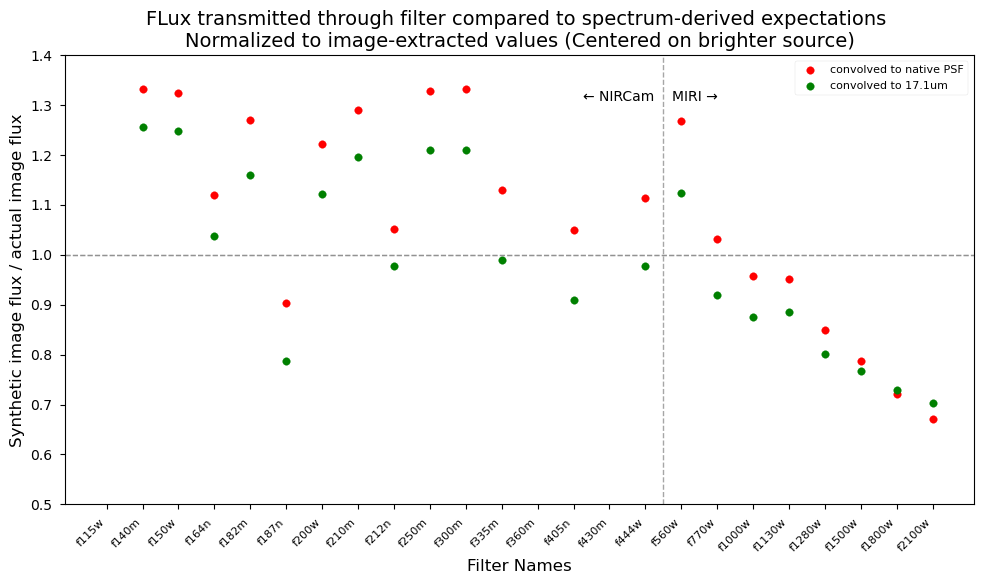

In [18]:
#This just plots the data created above (if it's already made)

my_flux = np.load('Data_files/misc_data/new_loc_my_files.npy')
Grant_IFU_flux = np.load('Data_files/misc_data/new_loc_grant_files.npy')
pivot_flux = np.load('Data_files/misc_data/new_loc_pivot_files.npy')
x_axis = np.array([extract_filter_name(x) for x in filter_files])

plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
# Now plot with sorted data
plt.figure(figsize=(10, 6))
plt.scatter(x_axis, my_flux, label='convolved to native PSF', s=30, marker='o', color='red')
#plt.scatter(x_axis, Grant_IFU_flux, label='convolved to 17.1um', s=30, marker='o', color='blue')
plt.scatter(x_axis, pivot_flux, label='convolved to 17.1um', s=30, marker='o', color='green')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=10)
plt.legend(loc = 'upper right')
plt.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.5)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.ylim(0.5,1.4)
ymin, ymax = plt.ylim()
text_y_pos = ymax * 0.94

# Add NIRCam label to the left
plt.text(15.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

# Add MIRI label to the right
plt.text(15.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)
plt.xlabel('Filter Names')
plt.ylabel('Synthetic image flux / actual image flux')
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to image-extracted values (Centered on brighter source)")
plt.tight_layout()
plt.savefig(f"Data_files/misc_data/image_vs_spectra.pdf", bbox_inches='tight')
plt.show()

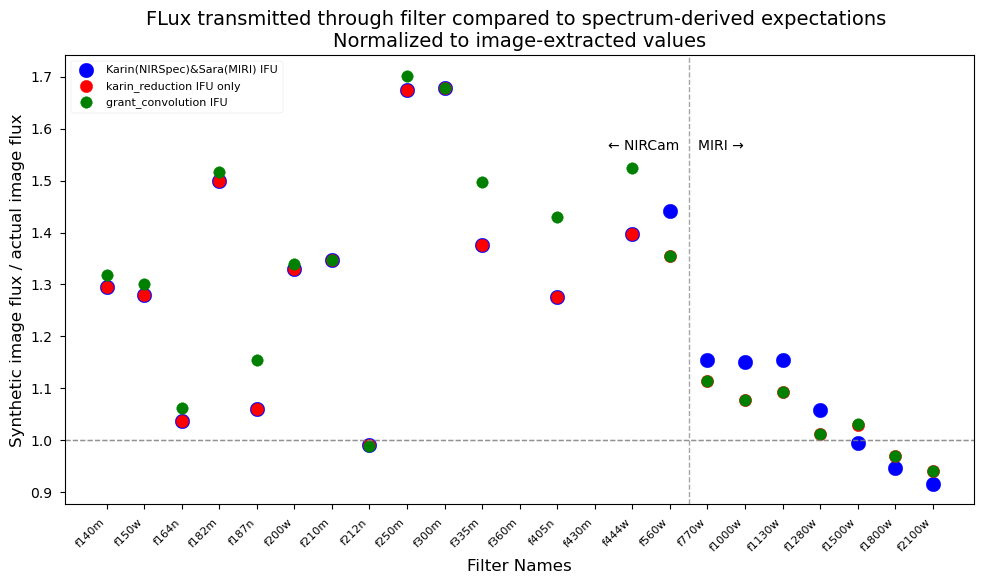

In [6]:
#This cell plots the various convolutions spec/photo flux ratios for each filter (must have the data already made)
image_flux = np.load('Data_files/misc_data/Image_fluxes.npy')

karin_stitched_expected = np.load('Data_files/misc_data/karin_stitched_and_convolved_expected_fluxes.npy')
rel_karin_stitched = karin_stitched_expected/image_flux

karin_SDuval_flux = np.load('Data_files/misc_data/Karin_SDuval_IFU_expected_flux.npy')
ksd_idx = [karin_SDuval_flux > 0][0]
ksd_rel_flux = np.array(karin_SDuval_flux/image_flux)[ksd_idx]

karin_IFU_flux = np.load('Data_files/misc_data/Karin_IFU_expected_flux.npy')
karin_idx = [karin_IFU_flux > 0][0]
rel_karin_flux = np.array(karin_IFU_flux/image_flux)[karin_idx]

grant_flux = np.load('Data_files/misc_data/Grant_IFU_expected_flux.npy')
grant_idx = [grant_flux > 0][0]
rel_grant = np.array(grant_flux/image_flux)[grant_idx]

Thomas_flux = np.load('Data_files/misc_data/Thomas_reduction_expected_fluxes.npy')
Thomas_idx = [11, 12, 13, 14, 15]
rel_Thomas = Thomas_flux/image_flux[Thomas_idx]

x_axis = np.array([extract_filter_name(x) for x in filter_files])

plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
# Now plot with sorted data
plt.figure(figsize=(10, 6))
#plt.scatter(x_axis, rel_karin_stitched, label='', s=30, marker='o', color='purple')
plt.scatter(x_axis[ksd_idx][1:], ksd_rel_flux[1:], label='Karin(NIRSpec)&Sara(MIRI) IFU', s=110, marker='o', color='blue')
plt.scatter(x_axis[karin_idx][1:], rel_karin_flux[1:], label='karin_reduction IFU only', s=80, marker='o', color='red')
plt.scatter(x_axis[grant_idx][1:], rel_grant[1:], label='grant_convolution IFU', s=70, marker='o', color='green')
#plt.scatter(x_axis[Thomas_idx], rel_Thomas, label='Thomas_reduction IFU', s=50, marker='o', color='black')
#plt.scatter(x_axis, rel_karin_stitched, label='Karin_stitched_and_convolved_spectrum', s=30, marker='o', color='purple')

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=10)
plt.legend(loc = 'upper left')
plt.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.5)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ymin, ymax = plt.ylim()
text_y_pos = ymax * 0.9

# Add NIRCam label to the left
plt.text(15.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

# Add MIRI label to the right
plt.text(15.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)
plt.xlabel('Filter Names')
plt.ylabel('Synthetic image flux / actual image flux')
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to image-extracted values")
plt.tight_layout()
plt.savefig(f"Data_files/misc_data/image_vs_spectra.pdf", bbox_inches='tight')
plt.show()


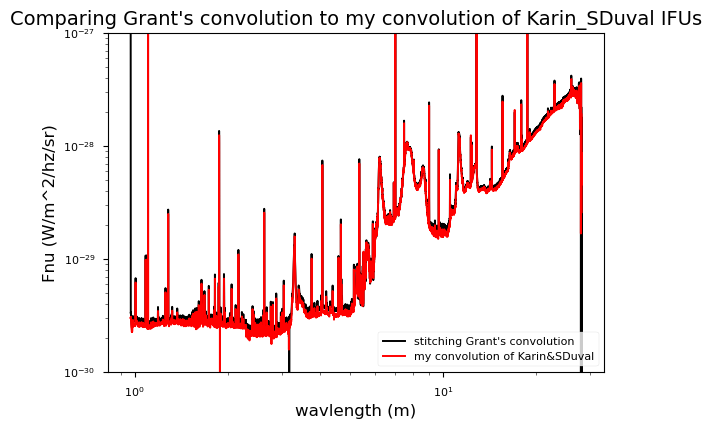

In [23]:
#Anchored to first file
Karin = load_and_sort_convolved_Karin_spectrum('Data_files/ARM2_HII2_conv_stitched_test.dat')
with open("Data_files/misc_data/Karin_SDuval_reduction_stitched.pkl", "rb") as file:
    full_spectrum = pickle.load(file)
test_range = range(0,len(Karin))
plt.plot(Karin['wavelength']*1e6, Karin['intensity'], color = 'black', label = "stitching Grant's convolution")
plt.plot(full_spectrum['wavelength'][test_range]*1e6, full_spectrum['intensity'][test_range], color = 'red', label = 'my convolution of Karin&SDuval')
plt.xscale('log')
plt.yscale('log')
plt.title("Comparing Grant's convolution to my convolution of Karin_SDuval IFUs")
plt.ylabel('Fnu (W/m^2/hz/sr)')
plt.xlabel('wavlength (m)')
plt.ylim([1e-30, 1e-27])
plt.legend()
plt.show()

In [12]:
def full_coverage(filter_name, IFU_file):
    '''Checks if the IFU has full filter converage or not'''
    filter_coverage = get_filter_wl_range(filter_name)
    cube = SpectralCube.read(IFU_file, hdu = 'SCI')
    cube_range = [cube.spectral_axis[0], cube.spectral_axis[-1]]
    if filter_coverage[0] < cube_range[0]:
        return 'missing shorter'
    if filter_coverage[1] > cube_range[1]:
        return'missing longer'
    else:
        return 'good'


array(['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits'],
      dtype='<U77')

1 nan values detected at wl: 9.703180286160204e-07 m within 0.88310546875 arcsec aperture in Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
Newly combined spectrum goes from 9.887620289519e-07 to 1.3283860351366507e-06
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
1 nan values detected at wl: 9.703180286160204e-07 m within 0.88310546875 arcsec aperture in Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths
Newly combined spectrum goes from 9.703180286160204e-07 to 1.8899740453634867e-06
Newly combined spectrum goes from 1.2819580342912e-06 to 1.536358038923972e-06
Newly combined spectrum go

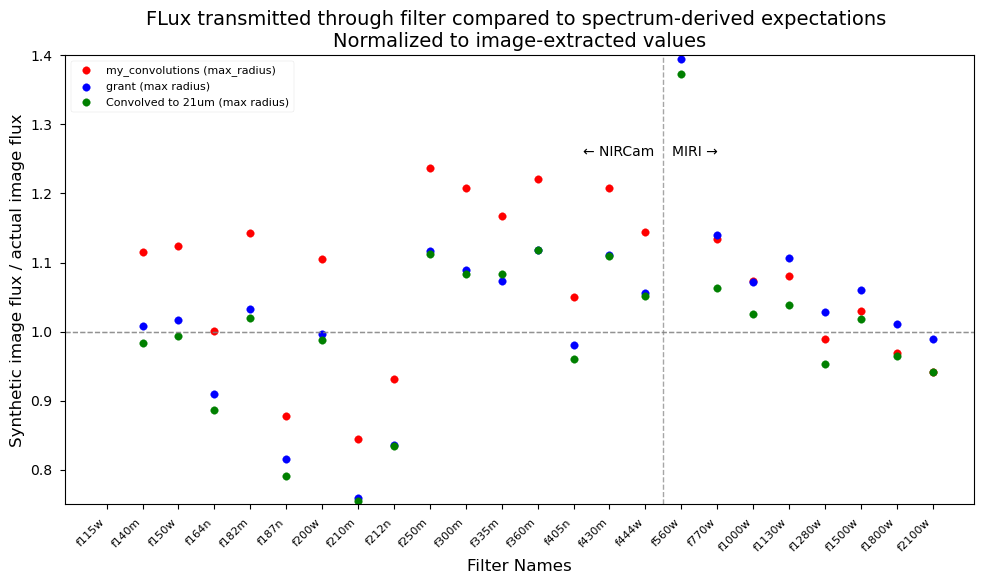

In [2]:
#This cell calculates the relative fluxes using the largest aperture that you can without spilling into unimaged regions

#This takes about 45-60 minutes
Grant_IFU_flux = []
my_flux = []
pivot_flux = []
for file in filter_files:
    
    current_filter_name = extract_filter_name(file).upper()
    image_file = [img for img in image_files if extract_filter_name(img).upper() == current_filter_name][0]
    
    radius = radius_dict[current_filter_name]
    
    needed_fits = which_fits(file, Grant_conv_IFU_files) #TJ extract needed IFU files
    needed_mine = [junk for junk in my_convolutions if junk.split('.f')[0].split('convolved_to')[-1] == current_filter_name]
    needed_pivot = which_fits(file, pivot_files)
    filter_data = []
    with open(file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
    anchor = 0
#    if current_filter_name == "F560W":
#        anchor = 1
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    g_spectrum = stitch_spectra(needed_fits, loc, radius, anchor_idx=anchor, replace_negatives = 0)
    g_photo_flux = get_image_flux(image_file, loc, radius)
    g_IFU_expected_flux = get_Fnu_transmission(g_spectrum["intensity"], g_spectrum["wavelength"], filter_trans, filter_wl)
    Grant_IFU_flux.append(g_IFU_expected_flux/g_photo_flux)

    
    my_spectrum = stitch_spectra(needed_mine, loc, radius, anchor_idx=anchor, replace_negatives = 0)
    my_photo_flux = get_image_flux(image_file, loc, radius)
    my_IFU_expected_flux = get_Fnu_transmission(my_spectrum["intensity"], my_spectrum["wavelength"], filter_trans, filter_wl)
    my_flux.append(my_IFU_expected_flux/my_photo_flux)

    p_spectrum = stitch_spectra(needed_pivot, loc, radius, anchor_idx=anchor, replace_negatives=0)
    p_photo_flux = get_image_flux(image_file, loc, radius)
    p_IFU_expected_flux = get_Fnu_transmission(p_spectrum["intensity"], p_spectrum["wavelength"], filter_trans, filter_wl)
    pivot_flux.append(p_IFU_expected_flux/p_photo_flux)
Grant_IFU_flux = np.array(Grant_IFU_flux)
my_flux = np.array(my_flux)
pivot_flux = np.array(pivot_flux)
np.save('Data_files/misc_data/my_expected_fluxes_max_radius.npy', my_flux)
np.save('Data_files/misc_data/Grant_IFU_expected_flux_max_radius.npy', Grant_IFU_flux)
np.save('Data_files/misc_data/pivot_IFU_expected_flux_max_radius.npy', pivot_flux)

pivot_flux = np.load('Data_files/misc_data/pivot_IFU_expected_flux_max_radius.npy')
my_flux = np.load('Data_files/misc_data/my_expected_fluxes_max_radius.npy')
Grant_IFU_flux = np.load('Data_files/misc_data/Grant_IFU_expected_flux_max_radius.npy')


image_flux_p75 = np.load('Data_files/misc_data/Image_fluxes.npy')
grant_flux_p75 = np.load('Data_files/misc_data/Grant_IFU_expected_flux.npy')
grant_idx = [grant_flux_p75 > 0][0]
rel_grant_p75 = np.array(grant_flux_p75/image_flux_p75)[grant_idx]
x_axis = np.array([extract_filter_name(x) for x in filter_files])

plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot

plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
# Now plot with sorted data
plt.figure(figsize=(10, 6))
plt.scatter(x_axis, my_flux, label='my_convolutions (max_radius)', s=30, marker='o', color='red')
plt.scatter(x_axis, Grant_IFU_flux, label='grant (max radius)', s=30, marker='o', color='blue')
plt.scatter(x_axis, pivot_flux, label='Convolved to 21um (max radius)', s=30, marker='o', color='green')
#plt.scatter(x_axis[grant_idx], rel_grant_p75, label='grant_original', s=30, marker='o', color='black', alpha = 0.3)

plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis='y', which='both', labelsize=10)
plt.legend(loc = 'upper left')
plt.axhline(y = 1, color = 'gray', linestyle = '--', linewidth = 1, alpha = 0.5)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.ylim(0.75,1.4)

ymin, ymax = plt.ylim()
text_y_pos = ymax * 0.9

# Add NIRCam label to the left
plt.text(15.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)

# Add MIRI label to the right
plt.text(15.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2),
         fontsize=10)
plt.xlabel('Filter Names')
plt.ylabel('Synthetic image flux / actual image flux')
plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to image-extracted values")
plt.tight_layout()
plt.savefig(f"Data_files/misc_data/image_vs_spectra.pdf", bbox_inches='tight')
plt.show()

# Plot results


In [64]:
#This cell generated the dictionary of largest radii available in the raw files, it does not need to be run again unless for new loc.
#Dictionary saved at bottom
'''
filter_max_radius = {}

for file in filter_files:
    current_filter_name = extract_filter_name(file).upper()
    
    # Find matching image file
    image_candidates = [img for img in image_files if extract_filter_name(img).upper() == current_filter_name]
    if not image_candidates:
        print(f"No matching image for filter {current_filter_name}")
        continue
    image_file = image_candidates[0]
    
    # Get corresponding IFU files
    needed_fits = which_fits(file, karin_SDuval_IFU_files)
    
    # Find maximum radius for each IFU and take the minimum (most conservative)
    radii = []
    for IFU in needed_fits:
        max_r = find_max_radius(IFU, image_file, loc)[0]
        radii.append(max_r)
    
    # Store in dictionary (only if we found valid radii)
    if radii:
        filter_max_radius[current_filter_name] = min(radii)
with open('Data_files/misc_data/flux_v_radius/maximum_radii.dic', 'wb') as f:
    pickle.dump(filter_max_radius, f)
'''
print()

More than one IFU file is needed for filter f300m
More than one IFU file is needed for filter f560w
More than one IFU file is needed for filter f770w
More than one IFU file is needed for filter f1130w
More than one IFU file is needed for filter f1280w
More than one IFU file is needed for filter f1800w
More than one IFU file is needed for filter f2100w


<Quantity 0.88310547 arcsec>

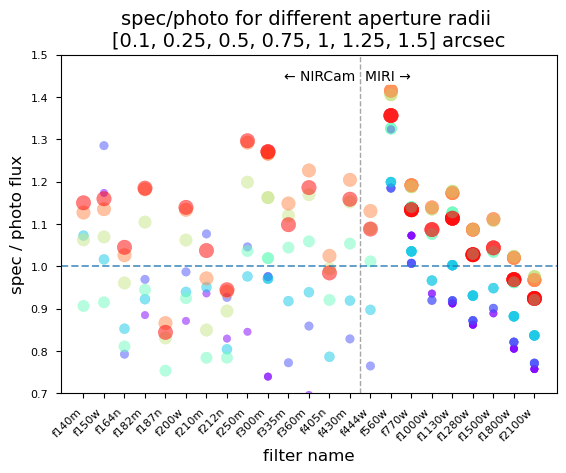

In [222]:
# Plot results
import matplotlib.cm as cm
import matplotlib.colors as mcolors
flux_ratios_dict = flux_ratios
#flux_ratios_array = np.array(flux_ratios)
fluxes = flux_ratios_dict['my_pivot']['flux']
sizes = flux_ratios_dict['my_pivot']['size']
idxs = flux_ratios_dict['my_pivot']['idx']

# Convert sizes to float if Quantity
sizes_float = np.array([s.value if hasattr(s, 'value') else s for s in sizes])
norm = mcolors.Normalize(vmin=np.min(sizes_float), vmax=np.max(sizes_float))
cmap = cm.get_cmap('rainbow')

# Map sizes to colors
colors = cmap(norm(sizes_float))
# Convert x data to your intended x_axis
x = np.array([x_axis[i] for i in idxs])
special_idx = np.isclose(sizes_float, 54.82, atol=0.5)  # Adjust atol as needed

# Set their color to black
colors[special_idx] = [0, 0, 0, 1] 
# Plot
mask = 9
plt.scatter(x[mask:], fluxes[mask:], s=sizes_float[mask:], c=colors[mask:], alpha=0.5)
#plt.yscale('log')
#plt.ylim(1e-2, 1e1)
plt.xticks(rotation=45, ha='right')
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.ylim(0.7, 1.5)

ymin, ymax = plt.ylim()
text_y_pos = 1.45
params = {'facecolor':'white', 'alpha':0.8, 'edgecolor':'none', 'pad':2}
# Add NIRCam label to the left
plt.text(13.25, text_y_pos, "← NIRCam", 
         ha='right', va='center', 
         bbox=params,
         fontsize=10)

# Add MIRI label to the right
plt.text(13.75, text_y_pos, "MIRI →", 
         ha='left', va='center', 
         bbox=params,
         fontsize=10)
plt.axhline(y=1, alpha = 0.7, linestyle = '--')
plt.title('spec/photo for different aperture radii \n[0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5] arcsec')
plt.xlabel('filter name')
plt.ylabel('spec / photo flux')
plt.show()


In [209]:
def get_aperture_flux(file, loc, radius, show_plot= False, zoom = None):
    '''display image of fits file, with aperture with radius at location, can also specify zoom
    -------------
    Parameters
    -------------
    file : type = str - string to fits file you want to display, can be a list of locations (len(loc) must equal len(radius))
    loc : type = either [ra, dec] in degrees, or a SkyCoord object - location of center of the aperture
    radius : type = angular unit - radius of aperture with units attached
    show_plot (optional, defaults to false) : type = Boolean - show png of image?
    zoom : type = angular unit, or list of units - width and height of the fov in the image if single value, if list [width, height]

    Returns
    -------------
    flux : type = float - in units of the image file, total flux through aperture.
    '''   

    hdul = fits.open(file)
    data = hdul[0].data
    header = hdul[0].header
    pix_area = header["PIXAR_SR"]
    # Create WCS object
    wcs = WCS(header)

    # Plot with imshow_norm
    if show_plot:
        try:
            plt.figure(figsize = (8,8*zoom[1]/zoom[0]))
        except:
            plt.figure(figsize=(8,8))
        ax = plt.subplot(projection=wcs)
        norm = simple_norm(data, stretch='asinh', percent=96.9)
        im = ax.imshow(data, norm=norm, cmap='gray', origin='lower')
        
        # Add RA/Dec gridlines and labels
        ax.coords.grid(True, color='white', ls='dotted')
        ax.coords[0].set_axislabel('RA')
        ax.coords[1].set_axislabel('Dec')
    if (type(loc[0]) == float) or (type(loc[0])==np.float64):
        x,y = wcs.all_world2pix(loc[0], loc[1], 0)
        aperture = CircularAperture((x, y), r=radius.to_value(u.deg) / header['CDELT2'])
        phot_result = aperture_photometry(data, aperture)
        flux = phot_result['aperture_sum'][0]
        if show_plot:
            aperture.plot(color='red', lw=2, alpha=0.7, label=f'{flux} MJy')
    else:
        flux = []
        for location in loc:
            x,y = wcs.all_world2pix(location[0], location[1], 0)
            aperture = CircularAperture((x, y), r=radius.to_value(u.deg) / header['CDELT2'])
            phot_result = aperture_photometry(data, aperture)
            this_flux = phot_result['aperture_sum'][0]*pix_area
            flux.append(this_flux)
            if show_plot:
                aperture.plot(color='red', lw=2, alpha=0.7, label=f'{radius}" Aperture')
    if show_plot and (zoom is not None):
        # Calculate half-width in pixels
        pix_scale = abs(header['CDELT2']) * u.deg  # pixel scale in deg/pix
        try:
            npix_half_x = (zoom[0].to(u.deg) / pix_scale).value / 2
            npix_half_y = (zoom[1].to(u.deg) / pix_scale).value / 2
            ax.set_xlim(x - npix_half_x, x + npix_half_x)
            ax.set_ylim(y - npix_half_y, y + npix_half_y)
        except:
            npix_half = (zoom.to(u.deg) / pix_scale).value / 2
            ax.set_xlim(x - npix_half, x + npix_half)
            ax.set_ylim(y - npix_half, y + npix_half)
    if show_plot:
        ax.legend()

        # Colorbar
        plt.colorbar(im, ax=ax, orientation='vertical', label='Flux')
        
        plt.title(f"{file.split('.fi')[0].split('/')[-1].split('/')[-1]}")
        plt.show()
    return flux
get_aperture_flux(image_files[-1], loc, radius, show_plot= True, zoom = None)

KeyError: "Keyword 'PIXAR_SR' not found."

More than one IFU file is needed for filter f300m
Using PSF at 2.996e-06 meters (filter pivot wavelength) for all slices


Convolving to F300M PSF:   0%|          | 0/1425 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as test_convolution_overwrite_ok0.fits
Using PSF at 2.996e-06 meters (filter pivot wavelength) for all slices


Convolving to F300M PSF:   0%|          | 0/1341 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as test_convolution_overwrite_ok1.fits
Using 10 radii between 0.1 and 0.8734375 arcsec
stitching convolved IFUs

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 3.174862210612695e-33
This corresponds to a correction of 0.026457144375549982
Newly combined spectrum goes from 1.6605299666407517e-06 to 5.269494898093397e-06
stitching raw IFUs jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits
1 nan values detected at wl: 3.169970021757762e-06 m within 0.1 arcsec aperture in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths

Stitching RIGHT: file 1 to combined
1 nan values detected at wl: 5.269494898093397e-06 m within 0.1 arcsec aperture in Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g39

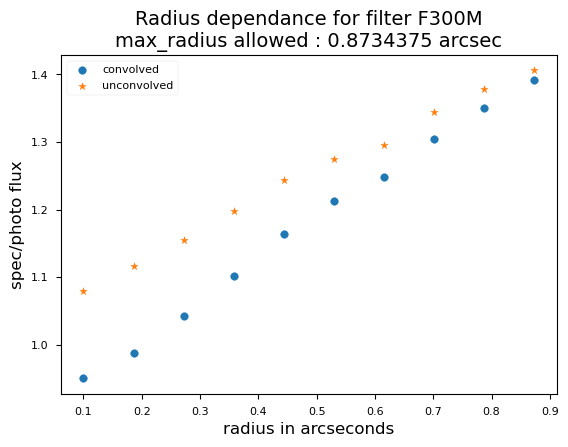

In [33]:
file = filter_files[10]
IFU_needed_files = which_fits(file, karin_SDuval_IFU_files)
filter_name = extract_filter_name(file).upper()
max_radius = radius_dict[filter_name]
new_fits = []
for i, IFU in enumerate(IFU_needed_files):      
    new_fits.append(convolve_using_reference(IFU, filter_name, output_file = f'test_convolution_overwrite_ok{i}.fits'))


image_candidates = [img for img in image_files if extract_filter_name(img).upper() == filter_name]
if not image_candidates:
    print(f"No matching image for filter {filter_name}")
image_file = image_candidates[0]

def radius_to_size(r, radii):
    min_radius = np.min(radii)
    max_radius = np.max(radii)
    # Linearly map radius to marker size between 30 and 110
    return 30 + (r - min_radius) / (max_radius - min_radius) * (110 - 30)

filter_files_maybe = [filt for filt in filter_files if extract_filter_name(filt).upper() == filter_name]
if not image_candidates:
    print(f"No matching image for filter {filter_name}")
filter_file = filter_files_maybe[0]


filter_data = []
with open(filter_file, 'r') as f:
    header = f.readline().strip().split()
    for line in f:
        data_line = line.strip().split()
        filter_data.append(data_line)
if len(filter_data) < 2:
    print(f"Filter file {filter_file} seems empty or malformed.")

header, filter_T = filter_data[:2], np.array(filter_data[2:])
filter_wl = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
filter_trans = np.array([try_float(row[1]) for row in filter_T])
relative_fluxes = []
raw_fluxes = []
radii = np.linspace(0.1, max_radius.value, 10)
print(f'Using 10 radii between 0.1 and {max_radius}')
for radius in radii:
    radius = radius*u.arcsec
    marker_size = radius_to_size(radius.value, radii)

    photo_flux = get_image_flux(image_file, test_loc, radius)
    print('stitching convolved IFUs')
    spectrum = stitch_spectra(new_fits, test_loc, radius)
    
    print('stitching raw IFUs', IFU_needed_files[0].split('/')[-1], IFU_needed_files[1].split('/')[-1])
    raw_spectrum = stitch_spectra(IFU_needed_files, test_loc, radius)
    print(raw_spectrum['wavelength'][0], raw_spectrum['wavelength'][-1])
    
    flux = get_Fnu_transmission(spectrum['intensity'], spectrum['wavelength'], filter_trans, filter_wl)/photo_flux
    raw_flux = get_Fnu_transmission(raw_spectrum['intensity'], raw_spectrum['wavelength'], filter_trans, filter_wl)/photo_flux
    
    relative_fluxes.append(flux)
    raw_fluxes.append(raw_flux)

flux_v_radius = np.array([relative_fluxes, radii])
raw_flux_v_radius = np.array([raw_fluxes, radii])
np.save(f'Data_files/misc_data/flux_v_radius/{filter_name}_radius_dependance', flux_v_radius)
if max(relative_fluxes) > 2:
    plt.ylim(0, 2)
    plt.ylabel(f'spec/photo flux \n(cut to < 2)')
else:
    plt.ylabel('spec/photo flux')
plt.scatter(radii, relative_fluxes, marker = 'o', label ='convolved')
plt.scatter(radii, raw_fluxes, marker = '*', label ='unconvolved')
plt.legend()
plt.title(f"Radius dependance for filter {filter_name}\nmax_radius allowed : {max_radius}")
plt.xlabel('radius in arcseconds')
plt.savefig(f'Data_files/misc_data/misc_plots/Radius_dependence_of_{filter_name}')
plt.show()

F115W IFU files: ['Data_files/IFU_files/my_convolutions/F115W/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF115W.fits']
F140M IFU files: ['Data_files/IFU_files/my_convolutions/F140M/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF140M.fits']
F150W IFU files: ['Data_files/IFU_files/my_convolutions/F150W/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF150W.fits']
F164N IFU files: ['Data_files/IFU_files/my_convolutions/F164N/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF164N.fits']
F182M IFU files: ['Data_files/IFU_files/my_convolutions/F182M/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF182M.fits']
F187N IFU files: ['Data_files/IFU_files/my_convolutions/F187N/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF187N.fits']
F200W IFU files: ['Data_files/IFU_files/my_convolutions/F200W/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_convolved_toF200W.fits']
F210M IFU files: ['Data_files/IFU_files/my_convolutions/F210M/jw03435-o012_t014_nirspec_g2

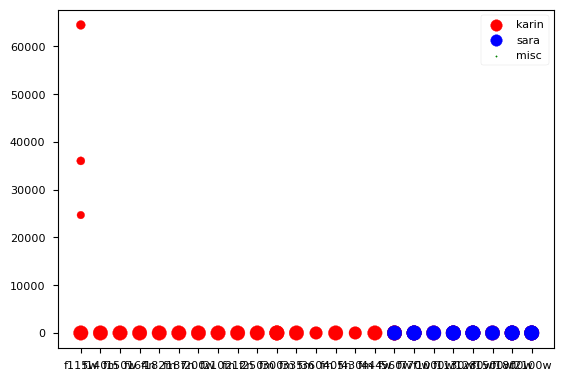

In [74]:
# Calculate all possible radii first for size scaling
radius_factors = [0.1, 0.25, 0.5, 1, 1.25, 1.5, 2, 3]
all_radii = np.array(radius_factors) * radius
min_radius = np.min(all_radii)
max_radius = np.max(all_radii)

def radius_to_size(r):
    # Linearly map radius to marker size between 30 and 110
    return 30 + (r - min_radius) / (max_radius - min_radius) * (110 - 30)

# Initialize storage including size
flux_ratios = {'karin': {'flux': [], 'idx': [], 'size': [], 'color': 'red'},
               'sara': {'flux': [], 'idx': [], 'size': [], 'color': 'blue'},
               'misc': {'flux': [], 'idx': [], 'size': [], 'color': 'green'}}

for j, filter_file in enumerate(filter_files):
    filter_name = extract_filter_name(filter_file).upper()

    # Match image file
    image_candidates = [img for img in image_files if extract_filter_name(img).upper() == filter_name]
    if not image_candidates:
        print(f"No matching image for filter {filter_name}")
        continue
    image_file = image_candidates[0]

    # Read filter data
    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
    if len(filter_data) < 2:
        print(f"Filter file {filter_file} seems empty or malformed.")
        continue

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
    filter_trans = np.array([try_float(row[1]) for row in filter_T])

    # Find compatible IFU files
    IFU_files = glob.glob(f"Data_files/IFU_files/my_convolutions/{filter_name}/*")
    print(f"{filter_name} IFU files:", IFU_files)

    for IFU_file in IFU_files:
        # Determine group
        filename = os.path.basename(IFU_file)
        if filename.startswith('SW'):
            group = 'sara'
        elif filename.startswith(('Arm', 'jw')):
            group = 'karin'
        else:
            group = 'misc'


        # For each radius factor, calculate flux and store
        for factor in radius_factors:
            test_radius = radius * factor
            marker_size = radius_to_size(test_radius)
    
            # Load or stitch spectrum once
            if full_coverage(filter_name, IFU_file) == 'good':
                spectrum = get_IFU_spectrum(IFU_file, loc, test_radius, replace_negatives=0.001)
            else:
                file_class = IFU_file.split('/')[-1][:2]
                if filter_name == "F560W":
                    files_to_stitch = ['Data_files/IFU_files/my_convolutions/F560W/jw03435-o012_t014_nirspec_g395m-f290lp_s3d_convolved_toF560W.fits', IFU_file]
                else:
                    files_to_stitch = glob.glob(f"Data_files/IFU_files/my_convolutions/{filter_name}/{file_class}*")
                try:
                    spectrum = stitch_spectra(files_to_stitch, loc, test_radius)
                    print(f'Stitched files for {filter_name}: {files_to_stitch}')
                except Exception as e:
                    print(f"Failed to stitch files for {filter_name}: {e}")
                    continue
            # Calculate photometric flux from image for this radius
            photo_flux = get_image_flux(image_file, loc, test_radius)

            # Calculate transmission flux for this radius
            flux = get_Fnu_transmission(spectrum['intensity'], spectrum['wavelength'], filter_trans, filter_wl)

            flux_ratios[group]['flux'].append(flux / photo_flux)
            flux_ratios[group]['idx'].append(j)
            flux_ratios[group]['size'].append(marker_size)
for group in flux_ratios:
    plt.scatter(x_axis[flux_ratios[group]['idx']],
                flux_ratios[group]['flux'],
                s=flux_ratios[group]['size'],
                color=flux_ratios[group]['color'],
                label=group)

plt.legend()
plt.show()

In [62]:

loc = [202.4340450, 47.1732517] 
radius = 0.75*u.arcsec
data = []
for i, file in enumerate(SDuval_IFU_files):
    IFU_hdul = fits.open(file)
    header = IFU_hdul["SCI"].header
    cube = SpectralCube.read(file, hdu='SCI')
    wcs = WCS(header)

    spectral_axis = cube.spectral_axis
    data.append(get_IFU_spectrum(file, loc, radius))

first_end = len(data[0]['wavelength'][data[0]['wavelength'] > data[1]['wavelength'][0]])
second_start = len(data[1]['wavelength'][data[1]['wavelength'] < data[0]['wavelength'][-1]])
second_end = len(data[1]['wavelength'][data[1]['wavelength'] > data[2]['wavelength'][0]])
third_start = len(data[2]['wavelength'][data[2]['wavelength'] < data[1]['wavelength'][-1]])
third_end = len(data[2]['wavelength'][data[2]['wavelength'] > data[3]['wavelength'][0]])
fourth_start = len(data[3]['wavelength'][data[3]['wavelength'] < data[2]['wavelength'][-1]])

nan values detected at wl: 2.8629000857938083e-05 m within aperture in Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d.fits! 
replacing them with 0, this may result in underestimated flux in aperture, ignoring this for future wavelengths


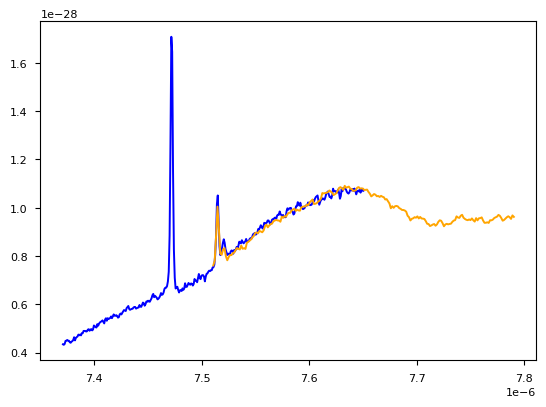

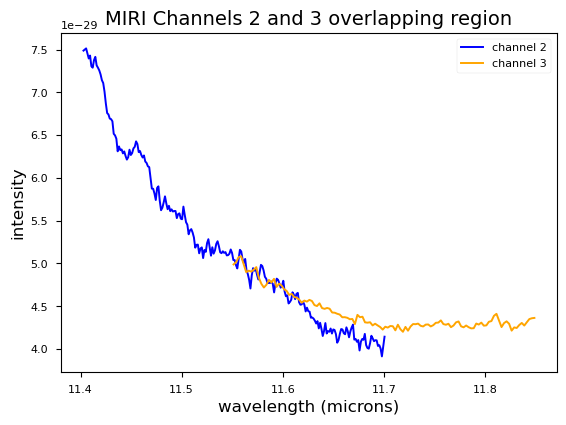

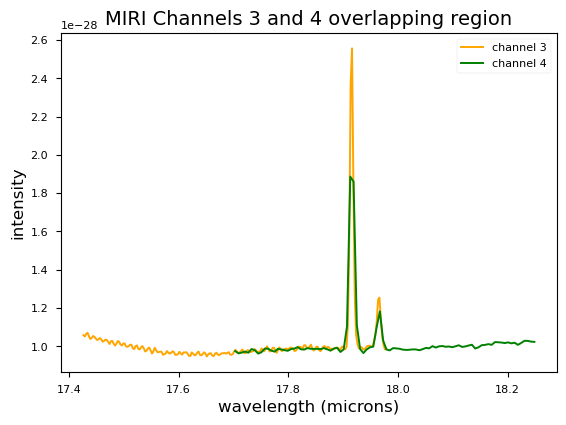

In [9]:

plt.plot(data[0]['wavelength'][-2*first_end:], data[0]['intensity'][-2*first_end:], color = 'blue', label = 'data1')
plt.plot(data[1]['wavelength'][:2*second_start], data[1]['intensity'][:2*second_start], color = 'orange', label = 'data2')
plt.show()
plt.plot(data[1]['wavelength'][-2*second_end:]*1e+6, data[1]['intensity'][-2*second_end:], color = 'blue', label = 'channel 2')
plt.plot(data[2]['wavelength'][:2*third_start]*1e+6, data[2]['intensity'][:2*third_start], color = 'orange', label = 'channel 3')
plt.xlabel('wavelength (microns)')
plt.ylabel('intensity')
plt.title('MIRI Channels 2 and 3 overlapping region')
plt.legend()
plt.show()
plt.plot(data[2]['wavelength'][-2*third_end:]*1e+6, data[2]['intensity'][-2*third_end:], color = 'orange', label = 'channel 3')
plt.plot(data[3]['wavelength'][:2*fourth_start]*1e+6, data[3]['intensity'][:2*fourth_start], color = 'green', label = 'channel 4')
plt.xlabel('wavelength (microns)')
plt.ylabel('intensity')
plt.title('MIRI Channels 3 and 4 overlapping region')
plt.legend()
plt.show()

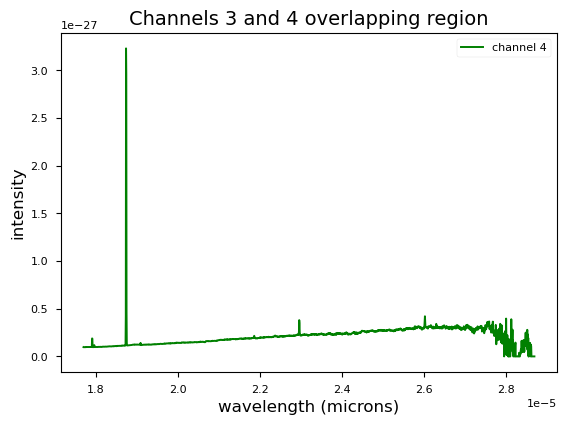

In [10]:
plt.plot(data[3]['wavelength'], data[3]['intensity'], color = 'green', label = 'channel 4')
plt.xlabel('wavelength (microns)')
plt.ylabel('intensity')
plt.title('Channels 3 and 4 overlapping region')
plt.legend()
plt.show()

In [ ]:

spectrum = find_point_spectrum(files[0], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[-2*first_end:], spectrum[-2*first_end:], color = 'red', label = 'channel 1')

spectrum = find_point_spectrum(files[1], loc)
wavelengths = spectrum.spectral_axis

plt.plot(wavelengths[:2*second_start], spectrum[:2*second_start], color = 'orange', label = 'channel 2')
plt.legend()
plt.show()

############################
spectrum = find_point_spectrum(files[1], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[-2*second_end:], spectrum[-2*second_end:], color = 'orange', label = 'channel 2')

spectrum = find_point_spectrum(files[2], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[:2*third_start], spectrum[:2*third_start], color = 'green', label = 'channel 3')
plt.legend()
plt.show()

#######################
spectrum = find_point_spectrum(files[2], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[-2*third_end:], spectrum[-2*third_end:], color = 'green', label = 'channel 3')

spectrum = find_point_spectrum(files[3], loc)
wavelengths = spectrum.spectral_axis
plt.plot(wavelengths[:2*fourth_start], spectrum[:2*fourth_start], color = 'blue', label = 'channel 4')
plt.legend()
plt.show()

In [13]:
starts = []
ends = []
for i,file in enumerate(karin_SDuval_IFU_files):
    cube = SpectralCube.read(file, hdu='SCI')
    starts.append(cube.spectral_axis[0].value*1e-6)
    ends.append(cube.spectral_axis[-1].value*1e-6)
    

In [14]:
convolved_fits = glob.glob('Data_files/IFU_files/*convolved*')
for file in convolved_fits:
    cube = SpectralCube.read(file)
    cube_wl = cube.spectral_axis
    filter_name = get_convolved_filter_name(file)
    filter_range = get_filter_wl_range(filter_name)
    print('filter spans ', filter_range)
    print('cube spans ', cube_wl[0], cube_wl[-1])
    if (filter_range[0].value > cube_wl[0].value*1e-6) & (filter_range[1].value < cube_wl[-1].value*1e-6):
        print('Fully contained')
    print()

IndexError: list index out of range

In [ ]:
cube = SpectralCube.read(IFU_file, hdu='SCI')
cube_wl = cube.spectral_axis.to(u.m)
wl1, wl2 = get_filter_wl_range(extract_filter_name(file).upper())
wl2.value

IFU pixel scale : 0.34999999403953536 arcsec
psf pixel scale : 0.02772925625 arcsec


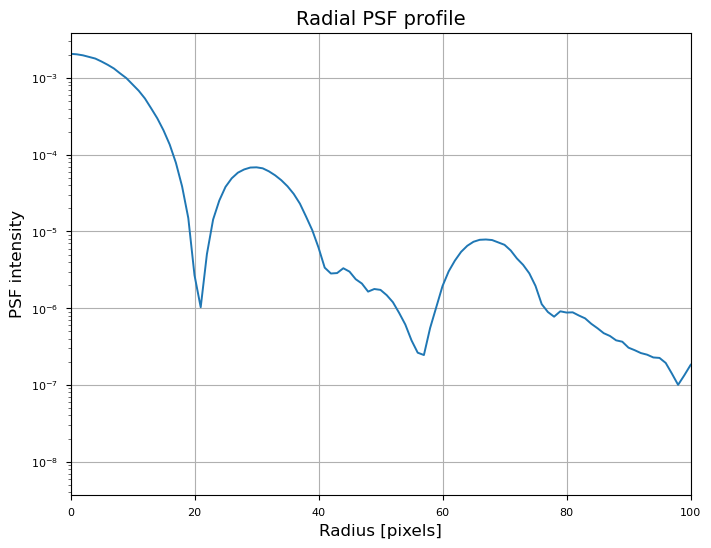

In [29]:
inst = webbpsf.MIRI()
inst.filter = 'F1500W'
psf = inst.calc_psf(monochromatic=1.5e-5)
psf_data = psf[0].data
hdu = fits.open(karin_IFU_files[-1])['SCI']
header = hdu.header
print('IFU pixel scale :', (header['CDELT2']*u.deg).to(u.arcsec))
print('psf pixel scale :', psf[0].header['PIXELSCL'], 'arcsec')

from astropy.modeling.models import Gaussian2D
import matplotlib.pyplot as plt

# Define center
ny, nx = psf_data.shape
y, x = np.indices(psf_data.shape)
cx, cy = nx // 2, ny // 2
r = np.sqrt((x - cx)**2 + (y - cy)**2)

# Flatten and sort by radius
r_flat = r.flatten()
psf_flat = psf_data.flatten()
sort_idx = np.argsort(r_flat)

r_sorted = r_flat[sort_idx]
psf_sorted = psf_flat[sort_idx]

# Bin radially
bin_size = 1  # pixel
my_max_r = int(r.max())
my_radial_median = [np.median(psf_data[(r >= i) & (r < i+bin_size)]) for i in range(my_max_r)]

plt.figure(figsize=(8,6))
plt.semilogy(range(my_max_r), my_radial_median)
plt.xlabel("Radius [pixels]")
plt.ylabel("PSF intensity")
plt.title("Radial PSF profile")
plt.xlim(0,100)
plt.grid(True)
plt.show()


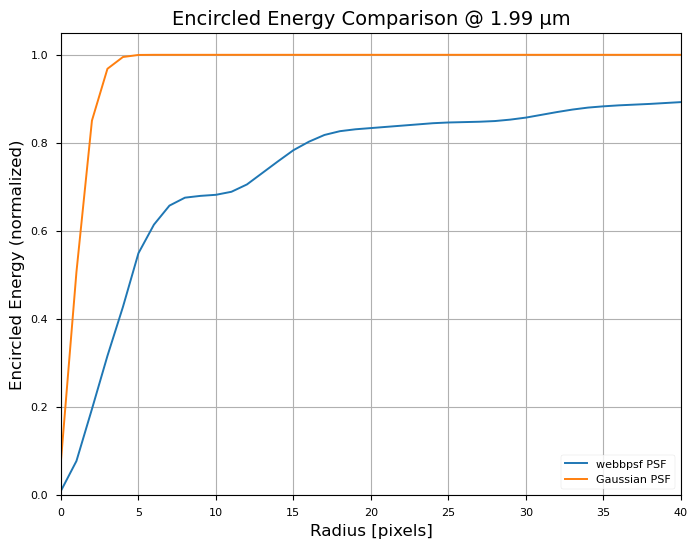

100%|██████████████████████████████████████████████████████████████████████████████| 1425/1425 [00:13<00:00, 107.50it/s]


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff7b2587ad0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff7b12cedd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff7b11a90d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff7b1204710>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff7b1211d90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff7b1011a90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff7b102fc90>]

In [31]:
from astropy.convolution import convolve, convolve_fft
from astropy.modeling.models import Gaussian2D
from photutils.psf.matching import create_matching_kernel
import numpy as np
from astropy.io import fits
from tqdm import tqdm
import matplotlib.pyplot as plt
import webbpsf

def convolve_JWST_cube_with_psf_plot(input_cubefile, target_lam, savename, target_inst, exclusion_threshold=0.9):
    '''
    Smooth a JWST cube to the resolution at a given wavelength and plot PSF comparison.
    '''
    NRS_handoff = 4.1 # micron

    def get_fwhm_MIRI(lam):
        return 0.033*(lam) + 0.106 # arcsec
    
    def get_x_fwhm_NRS(lamda):
        if lamda < NRS_handoff:
            return (0.01*lamda) + 0.14 # arcsec
        elif lamda >= NRS_handoff:
            return (0.02*lamda) + 0.15 # arcsec
    def get_y_fwhm_NRS(lamda):
        if lamda < NRS_handoff:
            return (0.01*lamda) + 0.16 # arcsec
        elif lamda >= NRS_handoff:
            return (0.01*lamda) + 0.15 # arcsec
    
    def get_spectral_axis(cube):
        wav_short = cube[1].header['CRVAL3']
        delta_lam = cube[1].header['CDELT3']
        lam_n = len(cube[1].data)
        spectral_axis = np.asarray([wav_short + (delta_lam*i) for i in range(lam_n)])
        return spectral_axis

    ### ==== PREP INPUT CUBE ==== ###
    input_cube = fits.open(input_cubefile)
    input_spectral_axis = get_spectral_axis(input_cube)
    input_slice = input_cube[1].data[0]
    if input_cube[0].header['INSTRUME'] == 'NIRSPEC':
        input_cube_type = 'NRS'
    elif input_cube[0].header['INSTRUME'] == 'MIRI':
        input_cube_type = 'MIRI'

    # Pixel grid for kernels
    y, x = np.mgrid[0:input_slice.shape[0], 0:input_slice.shape[1]]
    midx, midy = int(np.floor(input_slice.shape[1]/2)), int(np.floor(input_slice.shape[0]/2))

    ### ==== GET TARGET GAUSSIAN PSF ==== ###
    if target_inst == 'NRS':
        target_x_fwhm = get_x_fwhm_NRS(target_lam)
        target_sig_arcsec_x = target_x_fwhm/np.sqrt(8*np.log(2))
        target_sig_pix_x = target_sig_arcsec_x/np.sqrt(input_cube[1].header['PIXAR_A2'])
    
        target_y_fwhm = get_y_fwhm_NRS(target_lam)
        target_sig_arcsec_y = target_y_fwhm/np.sqrt(8*np.log(2))
        target_sig_pix_y = target_sig_arcsec_y/np.sqrt(input_cube[1].header['PIXAR_A2'])
    elif target_inst == 'MIRI':
        target_fwhm = get_fwhm_MIRI(target_lam)
        target_sig_arcsec = target_fwhm/np.sqrt(8*np.log(2))
        target_sig_pix_x = target_sig_arcsec/np.sqrt(input_cube[1].header['PIXAR_A2'])
        target_sig_pix_y = target_sig_pix_x

    target_gauss = Gaussian2D(1, midx, midy, target_sig_pix_x, target_sig_pix_y)
    target_kernel = target_gauss(x, y)

    ### ==== CALCULATE WEBBPSF PSF ==== ###
    inst = webbpsf.NIRCam()
    inst.filter = f'F200W'
    psf_webbpsf = inst.calc_psf(monochromatic=target_lam*1e-6)
    psf_data_webbpsf = psf_webbpsf[0].data
    psf_data_webbpsf /= psf_data_webbpsf.sum()

    ### ==== PLOT COMPARISON OF PSF ENIRCLED ENERGY ==== ###
    def compute_EE(psf_data):
        ny, nx = psf_data.shape
        y, x = np.indices(psf_data.shape)
        cx, cy = nx // 2, ny // 2
        r = np.sqrt((x - cx)**2 + (y - cy)**2)
        r_flat = r.flatten()
        psf_flat = psf_data.flatten()
        sort_idx = np.argsort(r_flat)
        r_sorted = r_flat[sort_idx]
        psf_sorted = psf_flat[sort_idx]

        max_r = int(r_sorted.max())
        EE = []
        for i in range(max_r):
            annulus_mask = (r_sorted >= 0) & (r_sorted < i+1)
            ee_value = psf_sorted[annulus_mask].sum()
            EE.append(ee_value)
        EE = np.array(EE) / psf_sorted.sum()  # normalize
        return EE, max_r

    EE_webbpsf, max_r_webbpsf = compute_EE(psf_data_webbpsf)
    EE_gauss, max_r_gauss = compute_EE(target_kernel)

    plt.figure(figsize=(8,6))
    plt.plot(range(max_r_webbpsf), EE_webbpsf, label='webbpsf PSF')
    plt.plot(range(max_r_gauss), EE_gauss, label='Gaussian PSF')
    plt.xlabel("Radius [pixels]")
    plt.ylabel("Encircled Energy (normalized)")
    plt.title(f"Encircled Energy Comparison @ {target_lam:.2f} μm")
    plt.ylim(0,1.05)
    plt.xlim(0,40)
    plt.grid(True)
    plt.legend()
    plt.show()

    ### ==== CONVOLUTION PROCESS ==== ###
    convolved_planes = []
    convolved_uncertainty_planes = []
    for i in tqdm(range(len(input_spectral_axis))):
        this_lam = input_spectral_axis[i]
        this_slice = input_cube[1].data[i]
        this_slice_unc = input_cube[2].data[i]

        if this_lam <= target_lam:
            if input_cube_type == 'NRS':
                this_x_fwhm_NRS = get_x_fwhm_NRS(this_lam)
                this_sig_arcsec_x = this_x_fwhm_NRS/np.sqrt(8*np.log(2))
                this_sig_pix_x = this_sig_arcsec_x/np.sqrt(input_cube[1].header['PIXAR_A2'])
                this_y_fwhm_NRS = get_y_fwhm_NRS(this_lam)
                this_sig_arcsec_y = this_y_fwhm_NRS/np.sqrt(8*np.log(2))
                this_sig_pix_y = this_sig_arcsec_y/np.sqrt(input_cube[1].header['PIXAR_A2'])
            elif input_cube_type == 'MIRI':
                this_x_fwhm_MIRI = get_fwhm_MIRI(this_lam)
                this_sig_arcsec_x = this_x_fwhm_MIRI/np.sqrt(8*np.log(2))
                this_sig_pix_x = this_sig_arcsec_x/np.sqrt(input_cube[1].header['PIXAR_A2'])
                this_sig_pix_y = this_sig_pix_x

            input_gauss = Gaussian2D(1, midx, midy, this_sig_pix_x, this_sig_pix_y)
            input_kernel = input_gauss(x, y)
            matching_kernel = create_matching_kernel(input_kernel, target_kernel)

            fake_slice = np.where(this_slice!=this_slice, 0, 1)
            fake_convolved_image = convolve_fft(fake_slice, matching_kernel, boundary='fill', fill_value=0, preserve_nan=True)
            keep_mask = np.where(fake_convolved_image>=exclusion_threshold, 1, np.nan)

            convolved_image = convolve_fft(this_slice, matching_kernel, boundary='fill', fill_value=0, preserve_nan=True)
            convolved_image *= keep_mask
            convolved_planes.append(convolved_image)

            unc_matching_kernel = matching_kernel**2
            unc_matching_kernel /= unc_matching_kernel.sum()
            convolved_unc_image = convolve_fft(this_slice_unc, unc_matching_kernel, boundary='fill', fill_value=0, preserve_nan=True)
            convolved_unc_image *= keep_mask
            convolved_uncertainty_planes.append(convolved_unc_image)
        else:
            convolved_planes.append(this_slice)
            convolved_uncertainty_planes.append(this_slice_unc)

    convolved_planes = np.asarray(convolved_planes)
    convolved_uncertainty_planes = np.asarray(convolved_uncertainty_planes)
    input_cube[1].data = convolved_planes
    input_cube[2].data = convolved_uncertainty_planes
    input_cube.writeto(savename, overwrite=True)

    return input_cube
convolve_JWST_cube_with_psf_plot(
    karin_IFU_files[1], 
    1.988, 
    'Data_files/IFU_files/testing_Grants_function.fits', 
    'NRS', 
    exclusion_threshold=0.9
)

0.9919655057865668


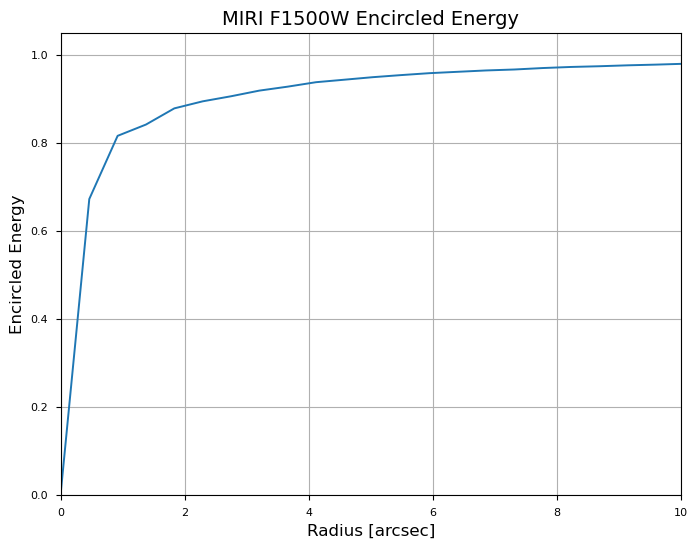

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
hdu = fits.open(karin_IFU_files[1])["SCI"]
header = hdu.header
pix_scale = (header["CDELT1"]*u.deg).to(u.arcsec)
inst = webbpsf.NIRCam()
inst.filter = 'F200W'
psf = inst.calc_psf(monochromatic=1.988e-6, fov_arcsec = 10)
psf_data = psf[0].data
# Re-normalize PSF
print(psf_data.sum())
psf_data /= psf_data.sum()

# Calculate EE in radial bins
ny, nx = psf_data.shape
y, x = np.indices(psf_data.shape)
cx, cy = nx // 2, ny // 2
r = np.sqrt((x - cx)**2 + (y - cy)**2)

r_arcsec = r * pix_scale

max_r_arcsec = r_arcsec.max()
bin_edges = np.linspace(0, max_r_arcsec, 100)
EE = []

for rmax in bin_edges:
    mask = r_arcsec <= rmax
    EE.append(psf_data[mask].sum())

plt.figure(figsize=(8,6))
plt.plot(bin_edges, EE)
plt.xlabel("Radius [arcsec]")
plt.ylabel("Encircled Energy")
plt.title("MIRI F1500W Encircled Energy")
plt.ylim(0,1.05)
plt.xlim(0,10)
plt.grid(True)
plt.show()


In [ ]:
cube = SpectralCube.read(karin_IFU_files[1], hdu = "SCI")
cube.spectral_axis[0]

In [ ]:
get_filter_wl_range('F200W')

In [ ]:
inst.calc_psf?

In [17]:
hdu = fits.open(karin_IFU_files[0])['SCI']
header = hdu.header
wcs = WCS(header)

In [21]:
wcs.wcs.crval[2]

9.703180286160204e-07

In [199]:
hdu = fits.open(karin_IFU_files[0])[0]
hdu.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-10-06T08:32:39.266' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits' / Name of the file  
SDP_VER = '2023_4a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-065'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '9.2     '           / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC30   '        